# Sciplex Dose

In [1]:
ood_seed = 4

In [2]:
num_ood = 1

In [3]:
obs_key = "condition"

In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn
import scipy.stats
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

12

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('Dex', '10.0'), 704)

Removed datapoint: 704


In [11]:
adata

AnnData object with n_obs × n_vars = 14107 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"sciplex_cat_ood-seed_expression-{ood_seed}_size-{num_ood}_obs-{obs_key}"
)

In [13]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [14]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|dose_training",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|condition",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [15]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = obs_key,
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
]

In [16]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=True
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['condition', 'dose_training']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

# tardis.MyModel.setup_wandb(
#     wandb_configurations=tardis.config.wandb,
#     hyperparams=dict(
#         model_params=model_params,
#         train_params=train_params,
#         dataset_params=dataset_params,
#     )
# )

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `training` set. Number of elements in each group: 1537,3008,2229,2762,1750
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `validation` set. Number of elements in each group: 402,756,531,727,405
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:05<53:38,  5.37s/it]

Epoch 1/600:   0%|          | 1/600 [00:05<53:38,  5.37s/it, v_num=1, total_loss_train=2.76e+3, kl_local_train=35.3]

Epoch 2/600:   0%|          | 1/600 [00:05<53:38,  5.37s/it, v_num=1, total_loss_train=2.76e+3, kl_local_train=35.3]

Epoch 2/600:   0%|          | 2/600 [00:10<51:28,  5.16s/it, v_num=1, total_loss_train=2.76e+3, kl_local_train=35.3]

Epoch 2/600:   0%|          | 2/600 [00:10<51:28,  5.16s/it, v_num=1, total_loss_train=2.24e+3, kl_local_train=61.6]

Epoch 3/600:   0%|          | 2/600 [00:10<51:28,  5.16s/it, v_num=1, total_loss_train=2.24e+3, kl_local_train=61.6]

Epoch 3/600:   0%|          | 3/600 [00:15<50:35,  5.09s/it, v_num=1, total_loss_train=2.24e+3, kl_local_train=61.6]

Epoch 3/600:   0%|          | 3/600 [00:15<50:35,  5.09s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=67]  

Epoch 4/600:   0%|          | 3/600 [00:15<50:35,  5.09s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=67]

Epoch 4/600:   1%|          | 4/600 [00:20<50:00,  5.03s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=67]

Epoch 4/600:   1%|          | 4/600 [00:20<50:00,  5.03s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=67.7]

Epoch 5/600:   1%|          | 4/600 [00:20<50:00,  5.03s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=67.7]

Epoch 5/600:   1%|          | 5/600 [00:25<51:15,  5.17s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=67.7]

Epoch 5/600:   1%|          | 5/600 [00:25<51:15,  5.17s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=65.4] 

Epoch 6/600:   1%|          | 5/600 [00:26<51:15,  5.17s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=65.4]

Epoch 6/600:   1%|          | 6/600 [00:30<50:47,  5.13s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=65.4]

Epoch 6/600:   1%|          | 6/600 [00:30<50:47,  5.13s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0334]

Epoch 7/600:   1%|          | 6/600 [00:30<50:47,  5.13s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0334]

Epoch 7/600:   1%|          | 7/600 [00:35<49:08,  4.97s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0334]

Epoch 7/600:   1%|          | 7/600 [00:35<49:08,  4.97s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=51, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0334] 

Epoch 8/600:   1%|          | 7/600 [00:35<49:08,  4.97s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=51, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0334]

Epoch 8/600:   1%|▏         | 8/600 [00:40<48:12,  4.89s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=51, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0334]

Epoch 8/600:   1%|▏         | 8/600 [00:40<48:12,  4.89s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0334]

Epoch 9/600:   1%|▏         | 8/600 [00:40<48:12,  4.89s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0334]

Epoch 9/600:   2%|▏         | 9/600 [00:44<47:35,  4.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0334]

Epoch 9/600:   2%|▏         | 9/600 [00:44<47:35,  4.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0334]

Epoch 10/600:   2%|▏         | 9/600 [00:44<47:35,  4.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0334]

Epoch 10/600:   2%|▏         | 10/600 [00:49<48:01,  4.88s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0334]

Epoch 10/600:   2%|▏         | 10/600 [00:49<48:01,  4.88s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0334]

Epoch 11/600:   2%|▏         | 10/600 [00:50<48:01,  4.88s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0334]

Epoch 11/600:   2%|▏         | 11/600 [00:54<48:35,  4.95s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0334]

Epoch 11/600:   2%|▏         | 11/600 [00:54<48:35,  4.95s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.175] 

Epoch 12/600:   2%|▏         | 11/600 [00:54<48:35,  4.95s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.175]

Epoch 12/600:   2%|▏         | 12/600 [00:59<47:40,  4.86s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.175]

Epoch 12/600:   2%|▏         | 12/600 [00:59<47:40,  4.86s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.175]

Epoch 13/600:   2%|▏         | 12/600 [00:59<47:40,  4.86s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.175]

Epoch 13/600:   2%|▏         | 13/600 [01:04<46:57,  4.80s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.175]

Epoch 13/600:   2%|▏         | 13/600 [01:04<46:57,  4.80s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.175]

Epoch 14/600:   2%|▏         | 13/600 [01:04<46:57,  4.80s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.175]

Epoch 14/600:   2%|▏         | 14/600 [01:08<46:26,  4.75s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.175]

Epoch 14/600:   2%|▏         | 14/600 [01:08<46:26,  4.75s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.175]

Epoch 15/600:   2%|▏         | 14/600 [01:08<46:26,  4.75s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.175]

Epoch 15/600:   2%|▎         | 15/600 [01:13<46:51,  4.81s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.175]

Epoch 15/600:   2%|▎         | 15/600 [01:13<46:51,  4.81s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.175]

Epoch 16/600:   2%|▎         | 15/600 [01:14<46:51,  4.81s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.175]

Epoch 16/600:   3%|▎         | 16/600 [01:18<47:36,  4.89s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.175]

Epoch 16/600:   3%|▎         | 16/600 [01:18<47:36,  4.89s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 17/600:   3%|▎         | 16/600 [01:18<47:36,  4.89s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 17/600:   3%|▎         | 17/600 [01:23<46:47,  4.82s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 17/600:   3%|▎         | 17/600 [01:23<46:47,  4.82s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 18/600:   3%|▎         | 17/600 [01:23<46:47,  4.82s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 18/600:   3%|▎         | 18/600 [01:28<46:10,  4.76s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 18/600:   3%|▎         | 18/600 [01:28<46:10,  4.76s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 19/600:   3%|▎         | 18/600 [01:28<46:10,  4.76s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 19/600:   3%|▎         | 19/600 [01:32<45:47,  4.73s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 19/600:   3%|▎         | 19/600 [01:32<45:47,  4.73s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 20/600:   3%|▎         | 19/600 [01:32<45:47,  4.73s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 20/600:   3%|▎         | 20/600 [01:38<46:52,  4.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 20/600:   3%|▎         | 20/600 [01:38<46:52,  4.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 21/600:   3%|▎         | 20/600 [01:38<46:52,  4.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 21/600:   4%|▎         | 21/600 [01:43<48:01,  4.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 21/600:   4%|▎         | 21/600 [01:43<48:01,  4.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.184]

Epoch 22/600:   4%|▎         | 21/600 [01:43<48:01,  4.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.184]

Epoch 22/600:   4%|▎         | 22/600 [01:48<49:33,  5.14s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.184]

Epoch 22/600:   4%|▎         | 22/600 [01:48<49:33,  5.14s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.184]

Epoch 23/600:   4%|▎         | 22/600 [01:48<49:33,  5.14s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.184]

Epoch 23/600:   4%|▍         | 23/600 [01:54<50:33,  5.26s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.184]

Epoch 23/600:   4%|▍         | 23/600 [01:54<50:33,  5.26s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.184]

Epoch 24/600:   4%|▍         | 23/600 [01:54<50:33,  5.26s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.184]

Epoch 24/600:   4%|▍         | 24/600 [01:59<50:43,  5.28s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.184]

Epoch 24/600:   4%|▍         | 24/600 [01:59<50:43,  5.28s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.184]

Epoch 25/600:   4%|▍         | 24/600 [01:59<50:43,  5.28s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.184]

Epoch 25/600:   4%|▍         | 25/600 [02:05<51:55,  5.42s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.184]

Epoch 25/600:   4%|▍         | 25/600 [02:05<51:55,  5.42s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.184]

Epoch 26/600:   4%|▍         | 25/600 [02:05<51:55,  5.42s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.184]

Epoch 26/600:   4%|▍         | 26/600 [02:11<52:57,  5.54s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.184]

Epoch 26/600:   4%|▍         | 26/600 [02:11<52:57,  5.54s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.212]

Epoch 27/600:   4%|▍         | 26/600 [02:11<52:57,  5.54s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.212]

Epoch 27/600:   4%|▍         | 27/600 [02:16<52:23,  5.49s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.212]

Epoch 27/600:   4%|▍         | 27/600 [02:16<52:23,  5.49s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.212]

Epoch 28/600:   4%|▍         | 27/600 [02:16<52:23,  5.49s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.212]

Epoch 28/600:   5%|▍         | 28/600 [02:21<51:57,  5.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.212]

Epoch 28/600:   5%|▍         | 28/600 [02:21<51:57,  5.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.212]

Epoch 29/600:   5%|▍         | 28/600 [02:21<51:57,  5.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.212]

Epoch 29/600:   5%|▍         | 29/600 [02:27<51:37,  5.42s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.212]

Epoch 29/600:   5%|▍         | 29/600 [02:27<51:37,  5.42s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.212]

Epoch 30/600:   5%|▍         | 29/600 [02:27<51:37,  5.42s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.212]

Epoch 30/600:   5%|▌         | 30/600 [02:32<52:07,  5.49s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.212]

Epoch 30/600:   5%|▌         | 30/600 [02:32<52:07,  5.49s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.212]

Epoch 31/600:   5%|▌         | 30/600 [02:33<52:07,  5.49s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.212]

Epoch 31/600:   5%|▌         | 31/600 [02:38<52:55,  5.58s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.212]

Epoch 31/600:   5%|▌         | 31/600 [02:38<52:55,  5.58s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.24]  

Epoch 32/600:   5%|▌         | 31/600 [02:38<52:55,  5.58s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.24]

Epoch 32/600:   5%|▌         | 32/600 [02:44<52:13,  5.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.24]

Epoch 32/600:   5%|▌         | 32/600 [02:44<52:13,  5.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.24]

Epoch 33/600:   5%|▌         | 32/600 [02:44<52:13,  5.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.24]

Epoch 33/600:   6%|▌         | 33/600 [02:49<51:41,  5.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.24]

Epoch 33/600:   6%|▌         | 33/600 [02:49<51:41,  5.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.5, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.24]

Epoch 34/600:   6%|▌         | 33/600 [02:49<51:41,  5.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.5, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.24]

Epoch 34/600:   6%|▌         | 34/600 [02:54<51:17,  5.44s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.5, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.24]

Epoch 34/600:   6%|▌         | 34/600 [02:54<51:17,  5.44s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.24]

Epoch 35/600:   6%|▌         | 34/600 [02:54<51:17,  5.44s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.24]

Epoch 35/600:   6%|▌         | 35/600 [03:00<51:51,  5.51s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.24]

Epoch 35/600:   6%|▌         | 35/600 [03:00<51:51,  5.51s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.24]

Epoch 36/600:   6%|▌         | 35/600 [03:00<51:51,  5.51s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.24]

Epoch 36/600:   6%|▌         | 36/600 [03:06<52:36,  5.60s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.24]

Epoch 36/600:   6%|▌         | 36/600 [03:06<52:36,  5.60s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.247]

Epoch 37/600:   6%|▌         | 36/600 [03:06<52:36,  5.60s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.247]

Epoch 37/600:   6%|▌         | 37/600 [03:11<51:52,  5.53s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.247]

Epoch 37/600:   6%|▌         | 37/600 [03:11<51:52,  5.53s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.7, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.247]

Epoch 38/600:   6%|▌         | 37/600 [03:11<51:52,  5.53s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.7, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.247]

Epoch 38/600:   6%|▋         | 38/600 [03:17<51:20,  5.48s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.7, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.247]

Epoch 38/600:   6%|▋         | 38/600 [03:17<51:20,  5.48s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.247]

Epoch 39/600:   6%|▋         | 38/600 [03:17<51:20,  5.48s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.247]

Epoch 39/600:   6%|▋         | 39/600 [03:22<50:57,  5.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.247]

Epoch 39/600:   6%|▋         | 39/600 [03:22<50:57,  5.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.1, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.247]

Epoch 40/600:   6%|▋         | 39/600 [03:22<50:57,  5.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.1, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.247]

Epoch 40/600:   7%|▋         | 40/600 [03:28<51:18,  5.50s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.1, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.247]

Epoch 40/600:   7%|▋         | 40/600 [03:28<51:18,  5.50s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.247]

Epoch 41/600:   7%|▋         | 40/600 [03:28<51:18,  5.50s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.247]

Epoch 41/600:   7%|▋         | 41/600 [03:33<52:01,  5.58s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.247]

Epoch 41/600:   7%|▋         | 41/600 [03:33<52:01,  5.58s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.5, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.229]  

Epoch 42/600:   7%|▋         | 41/600 [03:33<52:01,  5.58s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.5, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.229]

Epoch 42/600:   7%|▋         | 42/600 [03:39<51:16,  5.51s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.5, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.229]

Epoch 42/600:   7%|▋         | 42/600 [03:39<51:16,  5.51s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.229]

Epoch 43/600:   7%|▋         | 42/600 [03:39<51:16,  5.51s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.229]

Epoch 43/600:   7%|▋         | 43/600 [03:44<50:42,  5.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.229]

Epoch 43/600:   7%|▋         | 43/600 [03:44<50:42,  5.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.229]

Epoch 44/600:   7%|▋         | 43/600 [03:44<50:42,  5.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.229]

Epoch 44/600:   7%|▋         | 44/600 [03:49<50:16,  5.43s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.229]

Epoch 44/600:   7%|▋         | 44/600 [03:49<50:16,  5.43s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.229]

Epoch 45/600:   7%|▋         | 44/600 [03:49<50:16,  5.43s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.229]

Epoch 45/600:   8%|▊         | 45/600 [03:55<50:40,  5.48s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.229]

Epoch 45/600:   8%|▊         | 45/600 [03:55<50:40,  5.48s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.229]

Epoch 46/600:   8%|▊         | 45/600 [03:55<50:40,  5.48s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.229]

Epoch 46/600:   8%|▊         | 46/600 [04:01<52:00,  5.63s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.229]

Epoch 46/600:   8%|▊         | 46/600 [04:01<52:00,  5.63s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.5, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.232]

Epoch 47/600:   8%|▊         | 46/600 [04:01<52:00,  5.63s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.5, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.232]

Epoch 47/600:   8%|▊         | 47/600 [04:07<51:40,  5.61s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.5, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.232]

Epoch 47/600:   8%|▊         | 47/600 [04:07<51:40,  5.61s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.9, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.232]

Epoch 48/600:   8%|▊         | 47/600 [04:07<51:40,  5.61s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.9, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.232]

Epoch 48/600:   8%|▊         | 48/600 [04:12<51:25,  5.59s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.9, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.232]

Epoch 48/600:   8%|▊         | 48/600 [04:12<51:25,  5.59s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.232]

Epoch 49/600:   8%|▊         | 48/600 [04:12<51:25,  5.59s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.232]

Epoch 49/600:   8%|▊         | 49/600 [04:17<50:38,  5.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.232]

Epoch 49/600:   8%|▊         | 49/600 [04:17<50:38,  5.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.232]

Epoch 50/600:   8%|▊         | 49/600 [04:17<50:38,  5.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.232]

Epoch 50/600:   8%|▊         | 50/600 [04:23<50:56,  5.56s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.232]

Epoch 50/600:   8%|▊         | 50/600 [04:23<50:56,  5.56s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.232]

Epoch 51/600:   8%|▊         | 50/600 [04:23<50:56,  5.56s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.232]

Epoch 51/600:   8%|▊         | 51/600 [04:29<51:27,  5.62s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.232]

Epoch 51/600:   8%|▊         | 51/600 [04:29<51:27,  5.62s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.226]

Epoch 52/600:   8%|▊         | 51/600 [04:29<51:27,  5.62s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.226]

Epoch 52/600:   9%|▊         | 52/600 [04:34<50:36,  5.54s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.226]

Epoch 52/600:   9%|▊         | 52/600 [04:34<50:36,  5.54s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.226]

Epoch 53/600:   9%|▊         | 52/600 [04:34<50:36,  5.54s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.226]

Epoch 53/600:   9%|▉         | 53/600 [04:40<49:58,  5.48s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.226]

Epoch 53/600:   9%|▉         | 53/600 [04:40<49:58,  5.48s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.226]

Epoch 54/600:   9%|▉         | 53/600 [04:40<49:58,  5.48s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.226]

Epoch 54/600:   9%|▉         | 54/600 [04:45<49:30,  5.44s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.226]

Epoch 54/600:   9%|▉         | 54/600 [04:45<49:30,  5.44s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.226]

Epoch 55/600:   9%|▉         | 54/600 [04:45<49:30,  5.44s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.226]

Epoch 55/600:   9%|▉         | 55/600 [04:51<50:15,  5.53s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.226]

Epoch 55/600:   9%|▉         | 55/600 [04:51<50:15,  5.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.226]

Epoch 56/600:   9%|▉         | 55/600 [04:51<50:15,  5.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.226]

Epoch 56/600:   9%|▉         | 56/600 [04:56<50:50,  5.61s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.226]

Epoch 56/600:   9%|▉         | 56/600 [04:56<50:50,  5.61s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.224]

Epoch 57/600:   9%|▉         | 56/600 [04:56<50:50,  5.61s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.224]

Epoch 57/600:  10%|▉         | 57/600 [05:02<50:02,  5.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.224]

Epoch 57/600:  10%|▉         | 57/600 [05:02<50:02,  5.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.224]

Epoch 58/600:  10%|▉         | 57/600 [05:02<50:02,  5.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.224]

Epoch 58/600:  10%|▉         | 58/600 [05:07<49:27,  5.47s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.224]

Epoch 58/600:  10%|▉         | 58/600 [05:07<49:27,  5.47s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.224]

Epoch 59/600:  10%|▉         | 58/600 [05:07<49:27,  5.47s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.224]

Epoch 59/600:  10%|▉         | 59/600 [05:12<49:00,  5.43s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.224]

Epoch 59/600:  10%|▉         | 59/600 [05:12<49:00,  5.43s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.224]

Epoch 60/600:  10%|▉         | 59/600 [05:12<49:00,  5.43s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.224]

Epoch 60/600:  10%|█         | 60/600 [05:18<49:32,  5.50s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.224]

Epoch 60/600:  10%|█         | 60/600 [05:18<49:32,  5.50s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.224]

Epoch 61/600:  10%|█         | 60/600 [05:19<49:32,  5.50s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.224]

Epoch 61/600:  10%|█         | 61/600 [05:24<50:14,  5.59s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.224]

Epoch 61/600:  10%|█         | 61/600 [05:24<50:14,  5.59s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.22] 

Epoch 62/600:  10%|█         | 61/600 [05:24<50:14,  5.59s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.22]

Epoch 62/600:  10%|█         | 62/600 [05:29<49:31,  5.52s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.22]

Epoch 62/600:  10%|█         | 62/600 [05:29<49:31,  5.52s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.22]

Epoch 63/600:  10%|█         | 62/600 [05:29<49:31,  5.52s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.22]

Epoch 63/600:  10%|█         | 63/600 [05:35<48:59,  5.47s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.22]

Epoch 63/600:  10%|█         | 63/600 [05:35<48:59,  5.47s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.22]

Epoch 64/600:  10%|█         | 63/600 [05:35<48:59,  5.47s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.22]

Epoch 64/600:  11%|█         | 64/600 [05:40<48:33,  5.44s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.22]

Epoch 64/600:  11%|█         | 64/600 [05:40<48:33,  5.44s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.22]

Epoch 65/600:  11%|█         | 64/600 [05:40<48:33,  5.44s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.22]

Epoch 65/600:  11%|█         | 65/600 [05:46<49:20,  5.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.22]

Epoch 65/600:  11%|█         | 65/600 [05:46<49:20,  5.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.22]

Epoch 66/600:  11%|█         | 65/600 [05:46<49:20,  5.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.22]

Epoch 66/600:  11%|█         | 66/600 [05:52<49:55,  5.61s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.22]

Epoch 66/600:  11%|█         | 66/600 [05:52<49:55,  5.61s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.7, metric_mi|dose_training_train=0.0929, metric_mi|condition_train=0.223]

Epoch 67/600:  11%|█         | 66/600 [05:52<49:55,  5.61s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.7, metric_mi|dose_training_train=0.0929, metric_mi|condition_train=0.223]

Epoch 67/600:  11%|█         | 67/600 [05:57<49:07,  5.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.7, metric_mi|dose_training_train=0.0929, metric_mi|condition_train=0.223]

Epoch 67/600:  11%|█         | 67/600 [05:57<49:07,  5.53s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.0929, metric_mi|condition_train=0.223]

Epoch 68/600:  11%|█         | 67/600 [05:57<49:07,  5.53s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.0929, metric_mi|condition_train=0.223]

Epoch 68/600:  11%|█▏        | 68/600 [06:02<48:34,  5.48s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.0929, metric_mi|condition_train=0.223]

Epoch 68/600:  11%|█▏        | 68/600 [06:02<48:34,  5.48s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.0929, metric_mi|condition_train=0.223]

Epoch 69/600:  11%|█▏        | 68/600 [06:02<48:34,  5.48s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.0929, metric_mi|condition_train=0.223]

Epoch 69/600:  12%|█▏        | 69/600 [06:08<48:09,  5.44s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.0929, metric_mi|condition_train=0.223]

Epoch 69/600:  12%|█▏        | 69/600 [06:08<48:09,  5.44s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=83, metric_mi|dose_training_train=0.0929, metric_mi|condition_train=0.223]  

Epoch 70/600:  12%|█▏        | 69/600 [06:08<48:09,  5.44s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=83, metric_mi|dose_training_train=0.0929, metric_mi|condition_train=0.223]

Epoch 70/600:  12%|█▏        | 70/600 [06:13<48:31,  5.49s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=83, metric_mi|dose_training_train=0.0929, metric_mi|condition_train=0.223]

Epoch 70/600:  12%|█▏        | 70/600 [06:13<48:31,  5.49s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.0929, metric_mi|condition_train=0.223]

Epoch 71/600:  12%|█▏        | 70/600 [06:14<48:31,  5.49s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.0929, metric_mi|condition_train=0.223]

Epoch 71/600:  12%|█▏        | 71/600 [06:19<49:16,  5.59s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.0929, metric_mi|condition_train=0.223]

Epoch 71/600:  12%|█▏        | 71/600 [06:19<49:16,  5.59s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=81.5, metric_mi|dose_training_train=0.0981, metric_mi|condition_train=0.237]

Epoch 72/600:  12%|█▏        | 71/600 [06:19<49:16,  5.59s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=81.5, metric_mi|dose_training_train=0.0981, metric_mi|condition_train=0.237]

Epoch 72/600:  12%|█▏        | 72/600 [06:24<48:34,  5.52s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=81.5, metric_mi|dose_training_train=0.0981, metric_mi|condition_train=0.237]

Epoch 72/600:  12%|█▏        | 72/600 [06:24<48:34,  5.52s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.0981, metric_mi|condition_train=0.237]

Epoch 73/600:  12%|█▏        | 72/600 [06:24<48:34,  5.52s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.0981, metric_mi|condition_train=0.237]

Epoch 73/600:  12%|█▏        | 73/600 [06:30<48:02,  5.47s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.0981, metric_mi|condition_train=0.237]

Epoch 73/600:  12%|█▏        | 73/600 [06:30<48:02,  5.47s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.0981, metric_mi|condition_train=0.237]

Epoch 74/600:  12%|█▏        | 73/600 [06:30<48:02,  5.47s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.0981, metric_mi|condition_train=0.237]

Epoch 74/600:  12%|█▏        | 74/600 [06:35<47:40,  5.44s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.0981, metric_mi|condition_train=0.237]

Epoch 74/600:  12%|█▏        | 74/600 [06:35<47:40,  5.44s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=81.4, metric_mi|dose_training_train=0.0981, metric_mi|condition_train=0.237]

Epoch 75/600:  12%|█▏        | 74/600 [06:35<47:40,  5.44s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=81.4, metric_mi|dose_training_train=0.0981, metric_mi|condition_train=0.237]

Epoch 75/600:  12%|█▎        | 75/600 [06:41<48:33,  5.55s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=81.4, metric_mi|dose_training_train=0.0981, metric_mi|condition_train=0.237]

Epoch 75/600:  12%|█▎        | 75/600 [06:41<48:33,  5.55s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.0981, metric_mi|condition_train=0.237]

Epoch 76/600:  12%|█▎        | 75/600 [06:41<48:33,  5.55s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.0981, metric_mi|condition_train=0.237]

Epoch 76/600:  13%|█▎        | 76/600 [06:47<49:30,  5.67s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.0981, metric_mi|condition_train=0.237]

Epoch 76/600:  13%|█▎        | 76/600 [06:47<49:30,  5.67s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.237]

Epoch 77/600:  13%|█▎        | 76/600 [06:47<49:30,  5.67s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.237]

Epoch 77/600:  13%|█▎        | 77/600 [06:52<48:50,  5.60s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.237]

Epoch 77/600:  13%|█▎        | 77/600 [06:52<48:50,  5.60s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.237]  

Epoch 78/600:  13%|█▎        | 77/600 [06:52<48:50,  5.60s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.237]

Epoch 78/600:  13%|█▎        | 78/600 [06:58<48:28,  5.57s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.237]

Epoch 78/600:  13%|█▎        | 78/600 [06:58<48:28,  5.57s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.237]

Epoch 79/600:  13%|█▎        | 78/600 [06:58<48:28,  5.57s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.237]

Epoch 79/600:  13%|█▎        | 79/600 [07:03<47:49,  5.51s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.237]

Epoch 79/600:  13%|█▎        | 79/600 [07:03<47:49,  5.51s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.237]

Epoch 80/600:  13%|█▎        | 79/600 [07:03<47:49,  5.51s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.237]

Epoch 80/600:  13%|█▎        | 80/600 [07:09<48:03,  5.55s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.237]

Epoch 80/600:  13%|█▎        | 80/600 [07:09<48:03,  5.55s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.237]

Epoch 81/600:  13%|█▎        | 80/600 [07:09<48:03,  5.55s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.237]

Epoch 81/600:  14%|█▎        | 81/600 [07:15<48:36,  5.62s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.237]

Epoch 81/600:  14%|█▎        | 81/600 [07:15<48:36,  5.62s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]   

Epoch 82/600:  14%|█▎        | 81/600 [07:15<48:36,  5.62s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 82/600:  14%|█▎        | 82/600 [07:20<47:48,  5.54s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 82/600:  14%|█▎        | 82/600 [07:20<47:48,  5.54s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241] 

Epoch 83/600:  14%|█▎        | 82/600 [07:20<47:48,  5.54s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 83/600:  14%|█▍        | 83/600 [07:25<47:13,  5.48s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 83/600:  14%|█▍        | 83/600 [07:25<47:13,  5.48s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 84/600:  14%|█▍        | 83/600 [07:25<47:13,  5.48s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 84/600:  14%|█▍        | 84/600 [07:31<46:48,  5.44s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 84/600:  14%|█▍        | 84/600 [07:31<46:48,  5.44s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 85/600:  14%|█▍        | 84/600 [07:31<46:48,  5.44s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 85/600:  14%|█▍        | 85/600 [07:36<47:10,  5.50s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 85/600:  14%|█▍        | 85/600 [07:36<47:10,  5.50s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 86/600:  14%|█▍        | 85/600 [07:37<47:10,  5.50s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 86/600:  14%|█▍        | 86/600 [07:42<47:49,  5.58s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 86/600:  14%|█▍        | 86/600 [07:42<47:49,  5.58s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.24]   

Epoch 87/600:  14%|█▍        | 86/600 [07:42<47:49,  5.58s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.24]

Epoch 87/600:  14%|█▍        | 87/600 [07:47<47:08,  5.51s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.24]

Epoch 87/600:  14%|█▍        | 87/600 [07:47<47:08,  5.51s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.24]

Epoch 88/600:  14%|█▍        | 87/600 [07:47<47:08,  5.51s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.24]

Epoch 88/600:  15%|█▍        | 88/600 [07:53<46:38,  5.47s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.24]

Epoch 88/600:  15%|█▍        | 88/600 [07:53<46:38,  5.47s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.24]  

Epoch 89/600:  15%|█▍        | 88/600 [07:53<46:38,  5.47s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.24]

Epoch 89/600:  15%|█▍        | 89/600 [07:58<46:15,  5.43s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.24]

Epoch 89/600:  15%|█▍        | 89/600 [07:58<46:15,  5.43s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.24]

Epoch 90/600:  15%|█▍        | 89/600 [07:58<46:15,  5.43s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.24]

Epoch 90/600:  15%|█▌        | 90/600 [08:04<46:48,  5.51s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.24]

Epoch 90/600:  15%|█▌        | 90/600 [08:04<46:48,  5.51s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.24]

Epoch 91/600:  15%|█▌        | 90/600 [08:04<46:48,  5.51s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.24]

Epoch 91/600:  15%|█▌        | 91/600 [08:10<48:22,  5.70s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.24]

Epoch 91/600:  15%|█▌        | 91/600 [08:10<48:22,  5.70s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.8, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 92/600:  15%|█▌        | 91/600 [08:10<48:22,  5.70s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.8, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 92/600:  15%|█▌        | 92/600 [08:15<47:56,  5.66s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.8, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 92/600:  15%|█▌        | 92/600 [08:15<47:56,  5.66s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=75.8, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 93/600:  15%|█▌        | 92/600 [08:15<47:56,  5.66s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=75.8, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 93/600:  16%|█▌        | 93/600 [08:21<47:37,  5.64s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=75.8, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 93/600:  16%|█▌        | 93/600 [08:21<47:37,  5.64s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=75.8, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 94/600:  16%|█▌        | 93/600 [08:21<47:37,  5.64s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=75.8, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 94/600:  16%|█▌        | 94/600 [08:26<46:50,  5.55s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=75.8, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 94/600:  16%|█▌        | 94/600 [08:26<46:50,  5.55s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=75.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 95/600:  16%|█▌        | 94/600 [08:26<46:50,  5.55s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=75.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 95/600:  16%|█▌        | 95/600 [08:32<46:59,  5.58s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=75.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 95/600:  16%|█▌        | 95/600 [08:32<46:59,  5.58s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=75.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 96/600:  16%|█▌        | 95/600 [08:33<46:59,  5.58s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=75.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 96/600:  16%|█▌        | 96/600 [08:38<47:24,  5.64s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=75.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.241]

Epoch 96/600:  16%|█▌        | 96/600 [08:38<47:24,  5.64s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=75.5, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.236]

Epoch 97/600:  16%|█▌        | 96/600 [08:38<47:24,  5.64s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=75.5, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.236]

Epoch 97/600:  16%|█▌        | 97/600 [08:43<46:34,  5.56s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=75.5, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.236]

Epoch 97/600:  16%|█▌        | 97/600 [08:43<46:34,  5.56s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.236]

Epoch 98/600:  16%|█▌        | 97/600 [08:43<46:34,  5.56s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.236]

Epoch 98/600:  16%|█▋        | 98/600 [08:49<45:57,  5.49s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.236]

Epoch 98/600:  16%|█▋        | 98/600 [08:49<45:57,  5.49s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.1, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.236]

Epoch 99/600:  16%|█▋        | 98/600 [08:49<45:57,  5.49s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.1, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.236]

Epoch 99/600:  16%|█▋        | 99/600 [08:54<45:29,  5.45s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.1, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.236]

Epoch 99/600:  16%|█▋        | 99/600 [08:54<45:29,  5.45s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.236]

Epoch 100/600:  16%|█▋        | 99/600 [08:54<45:29,  5.45s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.236]

Epoch 100/600:  17%|█▋        | 100/600 [09:00<46:11,  5.54s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.236]

Epoch 100/600:  17%|█▋        | 100/600 [09:00<46:11,  5.54s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.3, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.236]

Epoch 101/600:  17%|█▋        | 100/600 [09:00<46:11,  5.54s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.3, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.236]

Epoch 101/600:  17%|█▋        | 101/600 [09:06<47:14,  5.68s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.3, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.236]

Epoch 101/600:  17%|█▋        | 101/600 [09:06<47:14,  5.68s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.4, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.234]

Epoch 102/600:  17%|█▋        | 101/600 [09:06<47:14,  5.68s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.4, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.234]

Epoch 102/600:  17%|█▋        | 102/600 [09:11<46:52,  5.65s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.4, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.234]

Epoch 102/600:  17%|█▋        | 102/600 [09:11<46:52,  5.65s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.234]  

Epoch 103/600:  17%|█▋        | 102/600 [09:11<46:52,  5.65s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.234]

Epoch 103/600:  17%|█▋        | 103/600 [09:17<46:34,  5.62s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.234]

Epoch 103/600:  17%|█▋        | 103/600 [09:17<46:34,  5.62s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.1, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.234]

Epoch 104/600:  17%|█▋        | 103/600 [09:17<46:34,  5.62s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.1, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.234]

Epoch 104/600:  17%|█▋        | 104/600 [09:22<46:21,  5.61s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.1, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.234]

Epoch 104/600:  17%|█▋        | 104/600 [09:22<46:21,  5.61s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.4, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.234]

Epoch 105/600:  17%|█▋        | 104/600 [09:22<46:21,  5.61s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.4, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.234]

Epoch 105/600:  18%|█▊        | 105/600 [09:28<46:42,  5.66s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.4, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.234]

Epoch 105/600:  18%|█▊        | 105/600 [09:28<46:42,  5.66s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.234]

Epoch 106/600:  18%|█▊        | 105/600 [09:29<46:42,  5.66s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.234]

Epoch 106/600:  18%|█▊        | 106/600 [09:34<47:29,  5.77s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.234]

Epoch 106/600:  18%|█▊        | 106/600 [09:34<47:29,  5.77s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.0969, metric_mi|condition_train=0.235]

Epoch 107/600:  18%|█▊        | 106/600 [09:34<47:29,  5.77s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.0969, metric_mi|condition_train=0.235]

Epoch 107/600:  18%|█▊        | 107/600 [09:40<46:55,  5.71s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.0969, metric_mi|condition_train=0.235]

Epoch 107/600:  18%|█▊        | 107/600 [09:40<46:55,  5.71s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0969, metric_mi|condition_train=0.235]

Epoch 108/600:  18%|█▊        | 107/600 [09:40<46:55,  5.71s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0969, metric_mi|condition_train=0.235]

Epoch 108/600:  18%|█▊        | 108/600 [09:45<45:56,  5.60s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0969, metric_mi|condition_train=0.235]

Epoch 108/600:  18%|█▊        | 108/600 [09:45<45:56,  5.60s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.6, metric_mi|dose_training_train=0.0969, metric_mi|condition_train=0.235]

Epoch 109/600:  18%|█▊        | 108/600 [09:45<45:56,  5.60s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.6, metric_mi|dose_training_train=0.0969, metric_mi|condition_train=0.235]

Epoch 109/600:  18%|█▊        | 109/600 [09:50<45:13,  5.53s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.6, metric_mi|dose_training_train=0.0969, metric_mi|condition_train=0.235]

Epoch 109/600:  18%|█▊        | 109/600 [09:50<45:13,  5.53s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.0969, metric_mi|condition_train=0.235]

Epoch 110/600:  18%|█▊        | 109/600 [09:50<45:13,  5.53s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.0969, metric_mi|condition_train=0.235]

Epoch 110/600:  18%|█▊        | 110/600 [09:56<45:36,  5.58s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.0969, metric_mi|condition_train=0.235]

Epoch 110/600:  18%|█▊        | 110/600 [09:56<45:36,  5.58s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0969, metric_mi|condition_train=0.235]

Epoch 111/600:  18%|█▊        | 110/600 [09:57<45:36,  5.58s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0969, metric_mi|condition_train=0.235]

Epoch 111/600:  18%|█▊        | 111/600 [10:02<46:32,  5.71s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0969, metric_mi|condition_train=0.235]

Epoch 111/600:  18%|█▊        | 111/600 [10:02<46:32,  5.71s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.7, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.236]

Epoch 112/600:  18%|█▊        | 111/600 [10:02<46:32,  5.71s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.7, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.236]

Epoch 112/600:  19%|█▊        | 112/600 [10:08<46:06,  5.67s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.7, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.236]

Epoch 112/600:  19%|█▊        | 112/600 [10:08<46:06,  5.67s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.236]

Epoch 113/600:  19%|█▊        | 112/600 [10:08<46:06,  5.67s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.236]

Epoch 113/600:  19%|█▉        | 113/600 [10:13<45:14,  5.57s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.236]

Epoch 113/600:  19%|█▉        | 113/600 [10:13<45:14,  5.57s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.236]

Epoch 114/600:  19%|█▉        | 113/600 [10:13<45:14,  5.57s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.236]

Epoch 114/600:  19%|█▉        | 114/600 [10:18<44:36,  5.51s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.236]

Epoch 114/600:  19%|█▉        | 114/600 [10:18<44:36,  5.51s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.1, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.236]

Epoch 115/600:  19%|█▉        | 114/600 [10:18<44:36,  5.51s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.1, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.236]

Epoch 115/600:  19%|█▉        | 115/600 [10:24<44:56,  5.56s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.1, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.236]

Epoch 115/600:  19%|█▉        | 115/600 [10:24<44:56,  5.56s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.236]  

Epoch 116/600:  19%|█▉        | 115/600 [10:25<44:56,  5.56s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.236]

Epoch 116/600:  19%|█▉        | 116/600 [10:30<45:25,  5.63s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.236]

Epoch 116/600:  19%|█▉        | 116/600 [10:30<45:25,  5.63s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.0993, metric_mi|condition_train=0.234]

Epoch 117/600:  19%|█▉        | 116/600 [10:30<45:25,  5.63s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.0993, metric_mi|condition_train=0.234]

Epoch 117/600:  20%|█▉        | 117/600 [10:35<44:39,  5.55s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.0993, metric_mi|condition_train=0.234]

Epoch 117/600:  20%|█▉        | 117/600 [10:35<44:39,  5.55s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.0993, metric_mi|condition_train=0.234]

Epoch 118/600:  20%|█▉        | 117/600 [10:35<44:39,  5.55s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.0993, metric_mi|condition_train=0.234]

Epoch 118/600:  20%|█▉        | 118/600 [10:41<44:07,  5.49s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.0993, metric_mi|condition_train=0.234]

Epoch 118/600:  20%|█▉        | 118/600 [10:41<44:07,  5.49s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.9, metric_mi|dose_training_train=0.0993, metric_mi|condition_train=0.234]

Epoch 119/600:  20%|█▉        | 118/600 [10:41<44:07,  5.49s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.9, metric_mi|dose_training_train=0.0993, metric_mi|condition_train=0.234]

Epoch 119/600:  20%|█▉        | 119/600 [10:46<43:42,  5.45s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.9, metric_mi|dose_training_train=0.0993, metric_mi|condition_train=0.234]

Epoch 119/600:  20%|█▉        | 119/600 [10:46<43:42,  5.45s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.4, metric_mi|dose_training_train=0.0993, metric_mi|condition_train=0.234]

Epoch 120/600:  20%|█▉        | 119/600 [10:46<43:42,  5.45s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.4, metric_mi|dose_training_train=0.0993, metric_mi|condition_train=0.234]

Epoch 120/600:  20%|██        | 120/600 [10:52<44:04,  5.51s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.4, metric_mi|dose_training_train=0.0993, metric_mi|condition_train=0.234]

Epoch 120/600:  20%|██        | 120/600 [10:52<44:04,  5.51s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.0993, metric_mi|condition_train=0.234]

Epoch 121/600:  20%|██        | 120/600 [10:52<44:04,  5.51s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.0993, metric_mi|condition_train=0.234]

Epoch 121/600:  20%|██        | 121/600 [10:57<44:41,  5.60s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.0993, metric_mi|condition_train=0.234]

Epoch 121/600:  20%|██        | 121/600 [10:57<44:41,  5.60s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.4, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.233] 

Epoch 122/600:  20%|██        | 121/600 [10:57<44:41,  5.60s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.4, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.233]

Epoch 122/600:  20%|██        | 122/600 [11:03<44:00,  5.52s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.4, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.233]

Epoch 122/600:  20%|██        | 122/600 [11:03<44:00,  5.52s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.233]

Epoch 123/600:  20%|██        | 122/600 [11:03<44:00,  5.52s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.233]

Epoch 123/600:  20%|██        | 123/600 [11:08<43:31,  5.47s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.233]

Epoch 123/600:  20%|██        | 123/600 [11:08<43:31,  5.47s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.233]

Epoch 124/600:  20%|██        | 123/600 [11:08<43:31,  5.47s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.233]

Epoch 124/600:  21%|██        | 124/600 [11:14<43:07,  5.44s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.233]

Epoch 124/600:  21%|██        | 124/600 [11:14<43:07,  5.44s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.233]

Epoch 125/600:  21%|██        | 124/600 [11:14<43:07,  5.44s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.233]

Epoch 125/600:  21%|██        | 125/600 [11:19<43:29,  5.49s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.233]

Epoch 125/600:  21%|██        | 125/600 [11:19<43:29,  5.49s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.2, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.233]

Epoch 126/600:  21%|██        | 125/600 [11:20<43:29,  5.49s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.2, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.233]

Epoch 126/600:  21%|██        | 126/600 [11:25<44:06,  5.58s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.2, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.233]

Epoch 126/600:  21%|██        | 126/600 [11:25<44:06,  5.58s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.235]

Epoch 127/600:  21%|██        | 126/600 [11:25<44:06,  5.58s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.235]

Epoch 127/600:  21%|██        | 127/600 [11:30<43:29,  5.52s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.235]

Epoch 127/600:  21%|██        | 127/600 [11:30<43:29,  5.52s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.7, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.235]

Epoch 128/600:  21%|██        | 127/600 [11:30<43:29,  5.52s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.7, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.235]

Epoch 128/600:  21%|██▏       | 128/600 [11:36<43:00,  5.47s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.7, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.235]

Epoch 128/600:  21%|██▏       | 128/600 [11:36<43:00,  5.47s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.235]

Epoch 129/600:  21%|██▏       | 128/600 [11:36<43:00,  5.47s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.235]

Epoch 129/600:  22%|██▏       | 129/600 [11:41<42:43,  5.44s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.235]

Epoch 129/600:  22%|██▏       | 129/600 [11:41<42:43,  5.44s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.235]

Epoch 130/600:  22%|██▏       | 129/600 [11:41<42:43,  5.44s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.235]

Epoch 130/600:  22%|██▏       | 130/600 [11:47<43:03,  5.50s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.235]

Epoch 130/600:  22%|██▏       | 130/600 [11:47<43:03,  5.50s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.8, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.235]

Epoch 131/600:  22%|██▏       | 130/600 [11:47<43:03,  5.50s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.8, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.235]

Epoch 131/600:  22%|██▏       | 131/600 [11:52<43:46,  5.60s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.8, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.235]

Epoch 131/600:  22%|██▏       | 131/600 [11:53<43:46,  5.60s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.1, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.234]

Epoch 132/600:  22%|██▏       | 131/600 [11:53<43:46,  5.60s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.1, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.234]

Epoch 132/600:  22%|██▏       | 132/600 [11:58<43:12,  5.54s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.1, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.234]

Epoch 132/600:  22%|██▏       | 132/600 [11:58<43:12,  5.54s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.234]

Epoch 133/600:  22%|██▏       | 132/600 [11:58<43:12,  5.54s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.234]

Epoch 133/600:  22%|██▏       | 133/600 [12:03<42:42,  5.49s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.234]

Epoch 133/600:  22%|██▏       | 133/600 [12:03<42:42,  5.49s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.234]

Epoch 134/600:  22%|██▏       | 133/600 [12:03<42:42,  5.49s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.234]

Epoch 134/600:  22%|██▏       | 134/600 [12:09<42:18,  5.45s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.234]

Epoch 134/600:  22%|██▏       | 134/600 [12:09<42:18,  5.45s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.234]

Epoch 135/600:  22%|██▏       | 134/600 [12:09<42:18,  5.45s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.234]

Epoch 135/600:  22%|██▎       | 135/600 [12:14<42:40,  5.51s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.234]

Epoch 135/600:  22%|██▎       | 135/600 [12:14<42:40,  5.51s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.234]

Epoch 136/600:  22%|██▎       | 135/600 [12:15<42:40,  5.51s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.234]

Epoch 136/600:  23%|██▎       | 136/600 [12:20<43:15,  5.59s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.234]

Epoch 136/600:  23%|██▎       | 136/600 [12:20<43:15,  5.59s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.235]   

Epoch 137/600:  23%|██▎       | 136/600 [12:20<43:15,  5.59s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.235]

Epoch 137/600:  23%|██▎       | 137/600 [12:25<42:36,  5.52s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.235]

Epoch 137/600:  23%|██▎       | 137/600 [12:25<42:36,  5.52s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.235]

Epoch 138/600:  23%|██▎       | 137/600 [12:25<42:36,  5.52s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.235]

Epoch 138/600:  23%|██▎       | 138/600 [12:31<42:07,  5.47s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.235]

Epoch 138/600:  23%|██▎       | 138/600 [12:31<42:07,  5.47s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.235]

Epoch 139/600:  23%|██▎       | 138/600 [12:31<42:07,  5.47s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.235]

Epoch 139/600:  23%|██▎       | 139/600 [12:36<41:44,  5.43s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.235]

Epoch 139/600:  23%|██▎       | 139/600 [12:36<41:44,  5.43s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.1, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.235]

Epoch 140/600:  23%|██▎       | 139/600 [12:36<41:44,  5.43s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.1, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.235]

Epoch 140/600:  23%|██▎       | 140/600 [12:42<42:20,  5.52s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.1, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.235]

Epoch 140/600:  23%|██▎       | 140/600 [12:42<42:20,  5.52s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.1, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.235]

Epoch 141/600:  23%|██▎       | 140/600 [12:42<42:20,  5.52s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.1, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.235]

Epoch 141/600:  24%|██▎       | 141/600 [12:48<42:52,  5.61s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.1, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.235]

Epoch 141/600:  24%|██▎       | 141/600 [12:48<42:52,  5.61s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69, metric_mi|dose_training_train=0.0995, metric_mi|condition_train=0.232]

Epoch 142/600:  24%|██▎       | 141/600 [12:48<42:52,  5.61s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69, metric_mi|dose_training_train=0.0995, metric_mi|condition_train=0.232]

Epoch 142/600:  24%|██▎       | 142/600 [12:53<42:12,  5.53s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69, metric_mi|dose_training_train=0.0995, metric_mi|condition_train=0.232]

Epoch 142/600:  24%|██▎       | 142/600 [12:53<42:12,  5.53s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.0995, metric_mi|condition_train=0.232]

Epoch 143/600:  24%|██▎       | 142/600 [12:53<42:12,  5.53s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.0995, metric_mi|condition_train=0.232]

Epoch 143/600:  24%|██▍       | 143/600 [12:58<41:42,  5.48s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.0995, metric_mi|condition_train=0.232]

Epoch 143/600:  24%|██▍       | 143/600 [12:58<41:42,  5.48s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0995, metric_mi|condition_train=0.232]

Epoch 144/600:  24%|██▍       | 143/600 [12:58<41:42,  5.48s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0995, metric_mi|condition_train=0.232]

Epoch 144/600:  24%|██▍       | 144/600 [13:04<41:20,  5.44s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0995, metric_mi|condition_train=0.232]

Epoch 144/600:  24%|██▍       | 144/600 [13:04<41:20,  5.44s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.0995, metric_mi|condition_train=0.232]

Epoch 145/600:  24%|██▍       | 144/600 [13:04<41:20,  5.44s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.0995, metric_mi|condition_train=0.232]

Epoch 145/600:  24%|██▍       | 145/600 [13:09<41:59,  5.54s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.0995, metric_mi|condition_train=0.232]

Epoch 145/600:  24%|██▍       | 145/600 [13:09<41:59,  5.54s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.3, metric_mi|dose_training_train=0.0995, metric_mi|condition_train=0.232]

Epoch 146/600:  24%|██▍       | 145/600 [13:10<41:59,  5.54s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.3, metric_mi|dose_training_train=0.0995, metric_mi|condition_train=0.232]

Epoch 146/600:  24%|██▍       | 146/600 [13:15<41:03,  5.43s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.3, metric_mi|dose_training_train=0.0995, metric_mi|condition_train=0.232]

Epoch 146/600:  24%|██▍       | 146/600 [13:15<41:03,  5.43s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.232]

Epoch 147/600:  24%|██▍       | 146/600 [13:15<41:03,  5.43s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.232]

Epoch 147/600:  24%|██▍       | 147/600 [13:19<39:09,  5.19s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.232]

Epoch 147/600:  24%|██▍       | 147/600 [13:19<39:09,  5.19s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.232]

Epoch 148/600:  24%|██▍       | 147/600 [13:19<39:09,  5.19s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.232]

Epoch 148/600:  25%|██▍       | 148/600 [13:24<37:48,  5.02s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.232]

Epoch 148/600:  25%|██▍       | 148/600 [13:24<37:48,  5.02s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.232]

Epoch 149/600:  25%|██▍       | 148/600 [13:24<37:48,  5.02s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.232]

Epoch 149/600:  25%|██▍       | 149/600 [13:28<36:49,  4.90s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.232]

Epoch 149/600:  25%|██▍       | 149/600 [13:28<36:49,  4.90s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.232]

Epoch 150/600:  25%|██▍       | 149/600 [13:29<36:49,  4.90s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.232]

Epoch 150/600:  25%|██▌       | 150/600 [13:33<36:55,  4.92s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.232]

Epoch 150/600:  25%|██▌       | 150/600 [13:33<36:55,  4.92s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.232]

Epoch 151/600:  25%|██▌       | 150/600 [13:34<36:55,  4.92s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.232]

Epoch 151/600:  25%|██▌       | 151/600 [13:39<37:07,  4.96s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.232]

Epoch 151/600:  25%|██▌       | 151/600 [13:39<37:07,  4.96s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.229]

Epoch 152/600:  25%|██▌       | 151/600 [13:39<37:07,  4.96s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.229]

Epoch 152/600:  25%|██▌       | 152/600 [13:43<36:17,  4.86s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.229]

Epoch 152/600:  25%|██▌       | 152/600 [13:43<36:17,  4.86s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.229]

Epoch 153/600:  25%|██▌       | 152/600 [13:43<36:17,  4.86s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.229]

Epoch 153/600:  26%|██▌       | 153/600 [13:48<35:39,  4.79s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.229]

Epoch 153/600:  26%|██▌       | 153/600 [13:48<35:39,  4.79s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.229]

Epoch 154/600:  26%|██▌       | 153/600 [13:48<35:39,  4.79s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.229]

Epoch 154/600:  26%|██▌       | 154/600 [13:52<35:12,  4.74s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.229]

Epoch 154/600:  26%|██▌       | 154/600 [13:52<35:12,  4.74s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.229]

Epoch 155/600:  26%|██▌       | 154/600 [13:52<35:12,  4.74s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.229]

Epoch 155/600:  26%|██▌       | 155/600 [13:57<35:47,  4.83s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.229]

Epoch 155/600:  26%|██▌       | 155/600 [13:57<35:47,  4.83s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.229]

Epoch 156/600:  26%|██▌       | 155/600 [13:58<35:47,  4.83s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.229]

Epoch 156/600:  26%|██▌       | 156/600 [14:02<36:11,  4.89s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.229]

Epoch 156/600:  26%|██▌       | 156/600 [14:02<36:11,  4.89s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.221]

Epoch 157/600:  26%|██▌       | 156/600 [14:02<36:11,  4.89s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.221]

Epoch 157/600:  26%|██▌       | 157/600 [14:07<35:31,  4.81s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.221]

Epoch 157/600:  26%|██▌       | 157/600 [14:07<35:31,  4.81s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.221]

Epoch 158/600:  26%|██▌       | 157/600 [14:07<35:31,  4.81s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.221]

Epoch 158/600:  26%|██▋       | 158/600 [14:12<35:01,  4.75s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.221]

Epoch 158/600:  26%|██▋       | 158/600 [14:12<35:01,  4.75s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.221]

Epoch 159/600:  26%|██▋       | 158/600 [14:12<35:01,  4.75s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.221]

Epoch 159/600:  26%|██▋       | 159/600 [14:16<34:39,  4.72s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.221]

Epoch 159/600:  26%|██▋       | 159/600 [14:16<34:39,  4.72s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.221]  

Epoch 160/600:  26%|██▋       | 159/600 [14:16<34:39,  4.72s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.221]

Epoch 160/600:  27%|██▋       | 160/600 [14:21<35:02,  4.78s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.221]

Epoch 160/600:  27%|██▋       | 160/600 [14:21<35:02,  4.78s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.221]

Epoch 161/600:  27%|██▋       | 160/600 [14:22<35:02,  4.78s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.221]

Epoch 161/600:  27%|██▋       | 161/600 [14:26<35:33,  4.86s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.221]

Epoch 161/600:  27%|██▋       | 161/600 [14:26<35:33,  4.86s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.217]

Epoch 162/600:  27%|██▋       | 161/600 [14:26<35:33,  4.86s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.217]

Epoch 162/600:  27%|██▋       | 162/600 [14:31<34:59,  4.79s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.217]

Epoch 162/600:  27%|██▋       | 162/600 [14:31<34:59,  4.79s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.217]

Epoch 163/600:  27%|██▋       | 162/600 [14:31<34:59,  4.79s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.217]

Epoch 163/600:  27%|██▋       | 163/600 [14:36<34:31,  4.74s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.217]

Epoch 163/600:  27%|██▋       | 163/600 [14:36<34:31,  4.74s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.217]

Epoch 164/600:  27%|██▋       | 163/600 [14:36<34:31,  4.74s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.217]

Epoch 164/600:  27%|██▋       | 164/600 [14:40<34:10,  4.70s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.217]

Epoch 164/600:  27%|██▋       | 164/600 [14:40<34:10,  4.70s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.217]

Epoch 165/600:  27%|██▋       | 164/600 [14:40<34:10,  4.70s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.217]

Epoch 165/600:  28%|██▊       | 165/600 [14:45<35:01,  4.83s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.217]

Epoch 165/600:  28%|██▊       | 165/600 [14:45<35:01,  4.83s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.217]

Epoch 166/600:  28%|██▊       | 165/600 [14:46<35:01,  4.83s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.217]

Epoch 166/600:  28%|██▊       | 166/600 [14:50<35:24,  4.90s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.217]

Epoch 166/600:  28%|██▊       | 166/600 [14:50<35:24,  4.90s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.213] 

Epoch 167/600:  28%|██▊       | 166/600 [14:50<35:24,  4.90s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.213]

Epoch 167/600:  28%|██▊       | 167/600 [14:55<34:43,  4.81s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.213]

Epoch 167/600:  28%|██▊       | 167/600 [14:55<34:43,  4.81s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.213]

Epoch 168/600:  28%|██▊       | 167/600 [14:55<34:43,  4.81s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.213]

Epoch 168/600:  28%|██▊       | 168/600 [15:00<34:12,  4.75s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.213]

Epoch 168/600:  28%|██▊       | 168/600 [15:00<34:12,  4.75s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.213]  

Epoch 169/600:  28%|██▊       | 168/600 [15:00<34:12,  4.75s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.213]

Epoch 169/600:  28%|██▊       | 169/600 [15:04<33:50,  4.71s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.213]

Epoch 169/600:  28%|██▊       | 169/600 [15:04<33:50,  4.71s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.213]

Epoch 170/600:  28%|██▊       | 169/600 [15:04<33:50,  4.71s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.213]

Epoch 170/600:  28%|██▊       | 170/600 [15:09<34:10,  4.77s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.213]

Epoch 170/600:  28%|██▊       | 170/600 [15:09<34:10,  4.77s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.213]

Epoch 171/600:  28%|██▊       | 170/600 [15:10<34:10,  4.77s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.213]

Epoch 171/600:  28%|██▊       | 171/600 [15:14<34:39,  4.85s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.213]

Epoch 171/600:  28%|██▊       | 171/600 [15:14<34:39,  4.85s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.214]

Epoch 172/600:  28%|██▊       | 171/600 [15:14<34:39,  4.85s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.214]

Epoch 172/600:  29%|██▊       | 172/600 [15:19<34:05,  4.78s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.214]

Epoch 172/600:  29%|██▊       | 172/600 [15:19<34:05,  4.78s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.7, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.214]

Epoch 173/600:  29%|██▊       | 172/600 [15:19<34:05,  4.78s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.7, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.214]

Epoch 173/600:  29%|██▉       | 173/600 [15:23<33:40,  4.73s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.7, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.214]

Epoch 173/600:  29%|██▉       | 173/600 [15:23<33:40,  4.73s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.214]

Epoch 174/600:  29%|██▉       | 173/600 [15:23<33:40,  4.73s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.214]

Epoch 174/600:  29%|██▉       | 174/600 [15:28<33:19,  4.69s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.214]

Epoch 174/600:  29%|██▉       | 174/600 [15:28<33:19,  4.69s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.214]

Epoch 175/600:  29%|██▉       | 174/600 [15:28<33:19,  4.69s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.214]

Epoch 175/600:  29%|██▉       | 175/600 [15:33<33:42,  4.76s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.214]

Epoch 175/600:  29%|██▉       | 175/600 [15:33<33:42,  4.76s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.214]

Epoch 176/600:  29%|██▉       | 175/600 [15:33<33:42,  4.76s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.214]

Epoch 176/600:  29%|██▉       | 176/600 [15:38<34:12,  4.84s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.214]

Epoch 176/600:  29%|██▉       | 176/600 [15:38<34:12,  4.84s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.215]

Epoch 177/600:  29%|██▉       | 176/600 [15:38<34:12,  4.84s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.215]

Epoch 177/600:  30%|██▉       | 177/600 [15:43<33:39,  4.77s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.215]

Epoch 177/600:  30%|██▉       | 177/600 [15:43<33:39,  4.77s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.215]

Epoch 178/600:  30%|██▉       | 177/600 [15:43<33:39,  4.77s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.215]

Epoch 178/600:  30%|██▉       | 178/600 [15:47<33:14,  4.73s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.215]

Epoch 178/600:  30%|██▉       | 178/600 [15:47<33:14,  4.73s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.215]

Epoch 179/600:  30%|██▉       | 178/600 [15:47<33:14,  4.73s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.215]

Epoch 179/600:  30%|██▉       | 179/600 [15:52<32:55,  4.69s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.215]

Epoch 179/600:  30%|██▉       | 179/600 [15:52<32:55,  4.69s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.215]

Epoch 180/600:  30%|██▉       | 179/600 [15:52<32:55,  4.69s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.215]

Epoch 180/600:  30%|███       | 180/600 [15:57<33:05,  4.73s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.215]

Epoch 180/600:  30%|███       | 180/600 [15:57<33:05,  4.73s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.215]

Epoch 181/600:  30%|███       | 180/600 [15:57<33:05,  4.73s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.215]

Epoch 181/600:  30%|███       | 181/600 [16:02<33:40,  4.82s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.215]

Epoch 181/600:  30%|███       | 181/600 [16:02<33:40,  4.82s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.222] 

Epoch 182/600:  30%|███       | 181/600 [16:02<33:40,  4.82s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.222]

Epoch 182/600:  30%|███       | 182/600 [16:06<33:10,  4.76s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.222]

Epoch 182/600:  30%|███       | 182/600 [16:06<33:10,  4.76s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.222]

Epoch 183/600:  30%|███       | 182/600 [16:06<33:10,  4.76s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.222]

Epoch 183/600:  30%|███       | 183/600 [16:11<32:46,  4.72s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.222]

Epoch 183/600:  30%|███       | 183/600 [16:11<32:46,  4.72s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.222]

Epoch 184/600:  30%|███       | 183/600 [16:11<32:46,  4.72s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.222]

Epoch 184/600:  31%|███       | 184/600 [16:15<32:29,  4.69s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.222]

Epoch 184/600:  31%|███       | 184/600 [16:15<32:29,  4.69s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.222]

Epoch 185/600:  31%|███       | 184/600 [16:15<32:29,  4.69s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.222]

Epoch 185/600:  31%|███       | 185/600 [16:21<33:16,  4.81s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.222]

Epoch 185/600:  31%|███       | 185/600 [16:21<33:16,  4.81s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.7, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.222]

Epoch 186/600:  31%|███       | 185/600 [16:21<33:16,  4.81s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.7, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.222]

Epoch 186/600:  31%|███       | 186/600 [16:26<33:40,  4.88s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.7, metric_mi|dose_training_train=0.091, metric_mi|condition_train=0.222]

Epoch 186/600:  31%|███       | 186/600 [16:26<33:40,  4.88s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.224]

Epoch 187/600:  31%|███       | 186/600 [16:26<33:40,  4.88s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.224]

Epoch 187/600:  31%|███       | 187/600 [16:30<33:02,  4.80s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.224]

Epoch 187/600:  31%|███       | 187/600 [16:30<33:02,  4.80s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.224]

Epoch 188/600:  31%|███       | 187/600 [16:30<33:02,  4.80s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.224]

Epoch 188/600:  31%|███▏      | 188/600 [16:35<32:36,  4.75s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.224]

Epoch 188/600:  31%|███▏      | 188/600 [16:35<32:36,  4.75s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.224]

Epoch 189/600:  31%|███▏      | 188/600 [16:35<32:36,  4.75s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.224]

Epoch 189/600:  32%|███▏      | 189/600 [16:39<32:15,  4.71s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.224]

Epoch 189/600:  32%|███▏      | 189/600 [16:39<32:15,  4.71s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.224]

Epoch 190/600:  32%|███▏      | 189/600 [16:39<32:15,  4.71s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.224]

Epoch 190/600:  32%|███▏      | 190/600 [16:44<32:22,  4.74s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.224]

Epoch 190/600:  32%|███▏      | 190/600 [16:44<32:22,  4.74s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.224]

Epoch 191/600:  32%|███▏      | 190/600 [16:45<32:22,  4.74s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.224]

Epoch 191/600:  32%|███▏      | 191/600 [16:49<32:55,  4.83s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.224]

Epoch 191/600:  32%|███▏      | 191/600 [16:49<32:55,  4.83s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.228]

Epoch 192/600:  32%|███▏      | 191/600 [16:49<32:55,  4.83s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.228]

Epoch 192/600:  32%|███▏      | 192/600 [16:54<32:28,  4.77s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.228]

Epoch 192/600:  32%|███▏      | 192/600 [16:54<32:28,  4.77s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.228]

Epoch 193/600:  32%|███▏      | 192/600 [16:54<32:28,  4.77s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.228]

Epoch 193/600:  32%|███▏      | 193/600 [16:59<32:05,  4.73s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.228]

Epoch 193/600:  32%|███▏      | 193/600 [16:59<32:05,  4.73s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.228]

Epoch 194/600:  32%|███▏      | 193/600 [16:59<32:05,  4.73s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.228]

Epoch 194/600:  32%|███▏      | 194/600 [17:03<31:49,  4.70s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.228]

Epoch 194/600:  32%|███▏      | 194/600 [17:03<31:49,  4.70s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.228]

Epoch 195/600:  32%|███▏      | 194/600 [17:03<31:49,  4.70s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.228]

Epoch 195/600:  32%|███▎      | 195/600 [17:08<32:20,  4.79s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.228]

Epoch 195/600:  32%|███▎      | 195/600 [17:08<32:20,  4.79s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.228]

Epoch 196/600:  32%|███▎      | 195/600 [17:09<32:20,  4.79s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.228]

Epoch 196/600:  33%|███▎      | 196/600 [17:13<32:49,  4.87s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.228]

Epoch 196/600:  33%|███▎      | 196/600 [17:13<32:49,  4.87s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 197/600:  33%|███▎      | 196/600 [17:13<32:49,  4.87s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 197/600:  33%|███▎      | 197/600 [17:18<32:17,  4.81s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 197/600:  33%|███▎      | 197/600 [17:18<32:17,  4.81s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 198/600:  33%|███▎      | 197/600 [17:18<32:17,  4.81s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 198/600:  33%|███▎      | 198/600 [17:23<31:53,  4.76s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 198/600:  33%|███▎      | 198/600 [17:23<31:53,  4.76s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 199/600:  33%|███▎      | 198/600 [17:23<31:53,  4.76s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 199/600:  33%|███▎      | 199/600 [17:27<31:35,  4.73s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 199/600:  33%|███▎      | 199/600 [17:27<31:35,  4.73s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 200/600:  33%|███▎      | 199/600 [17:27<31:35,  4.73s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 200/600:  33%|███▎      | 200/600 [17:32<32:22,  4.86s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 200/600:  33%|███▎      | 200/600 [17:32<32:22,  4.86s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 201/600:  33%|███▎      | 200/600 [17:33<32:22,  4.86s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 201/600:  34%|███▎      | 201/600 [17:37<32:43,  4.92s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 201/600:  34%|███▎      | 201/600 [17:37<32:43,  4.92s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.227]

Epoch 202/600:  34%|███▎      | 201/600 [17:37<32:43,  4.92s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.227]

Epoch 202/600:  34%|███▎      | 202/600 [17:42<32:06,  4.84s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.227]

Epoch 202/600:  34%|███▎      | 202/600 [17:42<32:06,  4.84s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.227]

Epoch 203/600:  34%|███▎      | 202/600 [17:42<32:06,  4.84s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.227]

Epoch 203/600:  34%|███▍      | 203/600 [17:47<31:38,  4.78s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.227]

Epoch 203/600:  34%|███▍      | 203/600 [17:47<31:38,  4.78s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.227]

Epoch 204/600:  34%|███▍      | 203/600 [17:47<31:38,  4.78s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.227]

Epoch 204/600:  34%|███▍      | 204/600 [17:51<31:18,  4.74s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.227]

Epoch 204/600:  34%|███▍      | 204/600 [17:51<31:18,  4.74s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.227]

Epoch 205/600:  34%|███▍      | 204/600 [17:51<31:18,  4.74s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.227]

Epoch 205/600:  34%|███▍      | 205/600 [17:57<31:58,  4.86s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.227]

Epoch 205/600:  34%|███▍      | 205/600 [17:57<31:58,  4.86s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.227]  

Epoch 206/600:  34%|███▍      | 205/600 [17:57<31:58,  4.86s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.227]

Epoch 206/600:  34%|███▍      | 206/600 [18:02<32:18,  4.92s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.227]

Epoch 206/600:  34%|███▍      | 206/600 [18:02<32:18,  4.92s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 207/600:  34%|███▍      | 206/600 [18:02<32:18,  4.92s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 207/600:  34%|███▍      | 207/600 [18:06<31:42,  4.84s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 207/600:  34%|███▍      | 207/600 [18:06<31:42,  4.84s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 208/600:  34%|███▍      | 207/600 [18:06<31:42,  4.84s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 208/600:  35%|███▍      | 208/600 [18:11<31:14,  4.78s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 208/600:  35%|███▍      | 208/600 [18:11<31:14,  4.78s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 209/600:  35%|███▍      | 208/600 [18:11<31:14,  4.78s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 209/600:  35%|███▍      | 209/600 [18:16<31:13,  4.79s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 209/600:  35%|███▍      | 209/600 [18:16<31:13,  4.79s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 210/600:  35%|███▍      | 209/600 [18:16<31:13,  4.79s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 210/600:  35%|███▌      | 210/600 [18:21<31:34,  4.86s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 210/600:  35%|███▌      | 210/600 [18:21<31:34,  4.86s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 211/600:  35%|███▌      | 210/600 [18:21<31:34,  4.86s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 211/600:  35%|███▌      | 211/600 [18:26<31:54,  4.92s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.225]

Epoch 211/600:  35%|███▌      | 211/600 [18:26<31:54,  4.92s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.221]

Epoch 212/600:  35%|███▌      | 211/600 [18:26<31:54,  4.92s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.221]

Epoch 212/600:  35%|███▌      | 212/600 [18:30<31:17,  4.84s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.221]

Epoch 212/600:  35%|███▌      | 212/600 [18:30<31:17,  4.84s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.221]

Epoch 213/600:  35%|███▌      | 212/600 [18:30<31:17,  4.84s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.221]

Epoch 213/600:  36%|███▌      | 213/600 [18:35<30:50,  4.78s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.221]

Epoch 213/600:  36%|███▌      | 213/600 [18:35<30:50,  4.78s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.221]

Epoch 214/600:  36%|███▌      | 213/600 [18:35<30:50,  4.78s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.221]

Epoch 214/600:  36%|███▌      | 214/600 [18:40<30:30,  4.74s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.221]

Epoch 214/600:  36%|███▌      | 214/600 [18:40<30:30,  4.74s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.221]

Epoch 215/600:  36%|███▌      | 214/600 [18:40<30:30,  4.74s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.221]

Epoch 215/600:  36%|███▌      | 215/600 [18:45<30:55,  4.82s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.221]

Epoch 215/600:  36%|███▌      | 215/600 [18:45<30:55,  4.82s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.221]

Epoch 216/600:  36%|███▌      | 215/600 [18:45<30:55,  4.82s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.221]

Epoch 216/600:  36%|███▌      | 216/600 [18:50<31:20,  4.90s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.221]

Epoch 216/600:  36%|███▌      | 216/600 [18:50<31:20,  4.90s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.216]  

Epoch 217/600:  36%|███▌      | 216/600 [18:50<31:20,  4.90s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.216]

Epoch 217/600:  36%|███▌      | 217/600 [18:54<30:46,  4.82s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.216]

Epoch 217/600:  36%|███▌      | 217/600 [18:54<30:46,  4.82s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.216]

Epoch 218/600:  36%|███▌      | 217/600 [18:54<30:46,  4.82s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.216]

Epoch 218/600:  36%|███▋      | 218/600 [18:59<30:22,  4.77s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.216]

Epoch 218/600:  36%|███▋      | 218/600 [18:59<30:22,  4.77s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.216]

Epoch 219/600:  36%|███▋      | 218/600 [18:59<30:22,  4.77s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.216]

Epoch 219/600:  36%|███▋      | 219/600 [19:04<30:02,  4.73s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.216]

Epoch 219/600:  36%|███▋      | 219/600 [19:04<30:02,  4.73s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.216]

Epoch 220/600:  36%|███▋      | 219/600 [19:04<30:02,  4.73s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.216]

Epoch 220/600:  37%|███▋      | 220/600 [19:09<30:27,  4.81s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.216]

Epoch 220/600:  37%|███▋      | 220/600 [19:09<30:27,  4.81s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.216]

Epoch 221/600:  37%|███▋      | 220/600 [19:09<30:27,  4.81s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.216]

Epoch 221/600:  37%|███▋      | 221/600 [19:14<30:52,  4.89s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.216]

Epoch 221/600:  37%|███▋      | 221/600 [19:14<30:52,  4.89s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.212]

Epoch 222/600:  37%|███▋      | 221/600 [19:14<30:52,  4.89s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.212]

Epoch 222/600:  37%|███▋      | 222/600 [19:18<30:20,  4.82s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.212]

Epoch 222/600:  37%|███▋      | 222/600 [19:18<30:20,  4.82s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.212]

Epoch 223/600:  37%|███▋      | 222/600 [19:18<30:20,  4.82s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.212]

Epoch 223/600:  37%|███▋      | 223/600 [19:23<29:55,  4.76s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.212]

Epoch 223/600:  37%|███▋      | 223/600 [19:23<29:55,  4.76s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.212]

Epoch 224/600:  37%|███▋      | 223/600 [19:23<29:55,  4.76s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.212]

Epoch 224/600:  37%|███▋      | 224/600 [19:28<29:38,  4.73s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.212]

Epoch 224/600:  37%|███▋      | 224/600 [19:28<29:38,  4.73s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.212]

Epoch 225/600:  37%|███▋      | 224/600 [19:28<29:38,  4.73s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.212]

Epoch 225/600:  38%|███▊      | 225/600 [19:33<29:45,  4.76s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.212]

Epoch 225/600:  38%|███▊      | 225/600 [19:33<29:45,  4.76s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.212]  

Epoch 226/600:  38%|███▊      | 225/600 [19:33<29:45,  4.76s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.212]

Epoch 226/600:  38%|███▊      | 226/600 [19:38<30:15,  4.86s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.212]

Epoch 226/600:  38%|███▊      | 226/600 [19:38<30:15,  4.86s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.209]

Epoch 227/600:  38%|███▊      | 226/600 [19:38<30:15,  4.86s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.209]

Epoch 227/600:  38%|███▊      | 227/600 [19:42<29:48,  4.80s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.209]

Epoch 227/600:  38%|███▊      | 227/600 [19:42<29:48,  4.80s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.209]

Epoch 228/600:  38%|███▊      | 227/600 [19:42<29:48,  4.80s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.209]

Epoch 228/600:  38%|███▊      | 228/600 [19:47<29:27,  4.75s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.209]

Epoch 228/600:  38%|███▊      | 228/600 [19:47<29:27,  4.75s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.209]

Epoch 229/600:  38%|███▊      | 228/600 [19:47<29:27,  4.75s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.209]

Epoch 229/600:  38%|███▊      | 229/600 [19:52<29:13,  4.73s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.209]

Epoch 229/600:  38%|███▊      | 229/600 [19:52<29:13,  4.73s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.209]  

Epoch 230/600:  38%|███▊      | 229/600 [19:52<29:13,  4.73s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.209]

Epoch 230/600:  38%|███▊      | 230/600 [19:56<29:20,  4.76s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.209]

Epoch 230/600:  38%|███▊      | 230/600 [19:56<29:20,  4.76s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.209]

Epoch 231/600:  38%|███▊      | 230/600 [19:57<29:20,  4.76s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.209]

Epoch 231/600:  38%|███▊      | 231/600 [20:02<29:50,  4.85s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.209]

Epoch 231/600:  38%|███▊      | 231/600 [20:02<29:50,  4.85s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.206]

Epoch 232/600:  38%|███▊      | 231/600 [20:02<29:50,  4.85s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.206]

Epoch 232/600:  39%|███▊      | 232/600 [20:06<29:23,  4.79s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.206]

Epoch 232/600:  39%|███▊      | 232/600 [20:06<29:23,  4.79s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.206]

Epoch 233/600:  39%|███▊      | 232/600 [20:06<29:23,  4.79s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.206]

Epoch 233/600:  39%|███▉      | 233/600 [20:11<29:03,  4.75s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.206]

Epoch 233/600:  39%|███▉      | 233/600 [20:11<29:03,  4.75s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.206]

Epoch 234/600:  39%|███▉      | 233/600 [20:11<29:03,  4.75s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.206]

Epoch 234/600:  39%|███▉      | 234/600 [20:16<28:47,  4.72s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.206]

Epoch 234/600:  39%|███▉      | 234/600 [20:16<28:47,  4.72s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.206]

Epoch 235/600:  39%|███▉      | 234/600 [20:16<28:47,  4.72s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.206]

Epoch 235/600:  39%|███▉      | 235/600 [20:20<29:01,  4.77s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.206]

Epoch 235/600:  39%|███▉      | 235/600 [20:20<29:01,  4.77s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.206]

Epoch 236/600:  39%|███▉      | 235/600 [20:21<29:01,  4.77s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.206]

Epoch 236/600:  39%|███▉      | 236/600 [20:25<29:28,  4.86s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.206]

Epoch 236/600:  39%|███▉      | 236/600 [20:25<29:28,  4.86s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.202]

Epoch 237/600:  39%|███▉      | 236/600 [20:25<29:28,  4.86s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.202]

Epoch 237/600:  40%|███▉      | 237/600 [20:30<29:01,  4.80s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.202]

Epoch 237/600:  40%|███▉      | 237/600 [20:30<29:01,  4.80s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.202]

Epoch 238/600:  40%|███▉      | 237/600 [20:30<29:01,  4.80s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.202]

Epoch 238/600:  40%|███▉      | 238/600 [20:35<28:39,  4.75s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.202]

Epoch 238/600:  40%|███▉      | 238/600 [20:35<28:39,  4.75s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.202]

Epoch 239/600:  40%|███▉      | 238/600 [20:35<28:39,  4.75s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.202]

Epoch 239/600:  40%|███▉      | 239/600 [20:39<28:23,  4.72s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.202]

Epoch 239/600:  40%|███▉      | 239/600 [20:39<28:23,  4.72s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.202]

Epoch 240/600:  40%|███▉      | 239/600 [20:39<28:23,  4.72s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.202]

Epoch 240/600:  40%|████      | 240/600 [20:44<28:34,  4.76s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.202]

Epoch 240/600:  40%|████      | 240/600 [20:44<28:34,  4.76s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.202]

Epoch 241/600:  40%|████      | 240/600 [20:45<28:34,  4.76s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.202]

Epoch 241/600:  40%|████      | 241/600 [20:49<29:02,  4.85s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.202]

Epoch 241/600:  40%|████      | 241/600 [20:49<29:02,  4.85s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]  

Epoch 242/600:  40%|████      | 241/600 [20:49<29:02,  4.85s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 242/600:  40%|████      | 242/600 [20:54<28:35,  4.79s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 242/600:  40%|████      | 242/600 [20:54<28:35,  4.79s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 243/600:  40%|████      | 242/600 [20:54<28:35,  4.79s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 243/600:  40%|████      | 243/600 [20:59<28:14,  4.75s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 243/600:  40%|████      | 243/600 [20:59<28:14,  4.75s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 244/600:  40%|████      | 243/600 [20:59<28:14,  4.75s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 244/600:  41%|████      | 244/600 [21:03<27:58,  4.71s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 244/600:  41%|████      | 244/600 [21:03<27:58,  4.71s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 245/600:  41%|████      | 244/600 [21:03<27:58,  4.71s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 245/600:  41%|████      | 245/600 [21:08<28:04,  4.74s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 245/600:  41%|████      | 245/600 [21:08<28:04,  4.74s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 246/600:  41%|████      | 245/600 [21:09<28:04,  4.74s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 246/600:  41%|████      | 246/600 [21:13<28:33,  4.84s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 246/600:  41%|████      | 246/600 [21:13<28:33,  4.84s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 247/600:  41%|████      | 246/600 [21:13<28:33,  4.84s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 247/600:  41%|████      | 247/600 [21:18<28:08,  4.78s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 247/600:  41%|████      | 247/600 [21:18<28:08,  4.78s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 248/600:  41%|████      | 247/600 [21:18<28:08,  4.78s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 248/600:  41%|████▏     | 248/600 [21:22<27:49,  4.74s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 248/600:  41%|████▏     | 248/600 [21:22<27:49,  4.74s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 249/600:  41%|████▏     | 248/600 [21:22<27:49,  4.74s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 249/600:  42%|████▏     | 249/600 [21:27<27:34,  4.71s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 249/600:  42%|████▏     | 249/600 [21:27<27:34,  4.71s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 250/600:  42%|████▏     | 249/600 [21:27<27:34,  4.71s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 250/600:  42%|████▏     | 250/600 [21:32<27:51,  4.78s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 250/600:  42%|████▏     | 250/600 [21:32<27:51,  4.78s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]  

Epoch 251/600:  42%|████▏     | 250/600 [21:32<27:51,  4.78s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 251/600:  42%|████▏     | 251/600 [21:37<28:16,  4.86s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.2]

Epoch 251/600:  42%|████▏     | 251/600 [21:37<28:16,  4.86s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.204]

Epoch 252/600:  42%|████▏     | 251/600 [21:37<28:16,  4.86s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.204]

Epoch 252/600:  42%|████▏     | 252/600 [21:42<27:48,  4.79s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.204]

Epoch 252/600:  42%|████▏     | 252/600 [21:42<27:48,  4.79s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.204]

Epoch 253/600:  42%|████▏     | 252/600 [21:42<27:48,  4.79s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.204]

Epoch 253/600:  42%|████▏     | 253/600 [21:46<27:27,  4.75s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.204]

Epoch 253/600:  42%|████▏     | 253/600 [21:46<27:27,  4.75s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.204]

Epoch 254/600:  42%|████▏     | 253/600 [21:46<27:27,  4.75s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.204]

Epoch 254/600:  42%|████▏     | 254/600 [21:51<27:11,  4.72s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.204]

Epoch 254/600:  42%|████▏     | 254/600 [21:51<27:11,  4.72s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.204]

Epoch 255/600:  42%|████▏     | 254/600 [21:51<27:11,  4.72s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.204]

Epoch 255/600:  42%|████▎     | 255/600 [21:56<27:24,  4.77s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.204]

Epoch 255/600:  42%|████▎     | 255/600 [21:56<27:24,  4.77s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.204]

Epoch 256/600:  42%|████▎     | 255/600 [21:56<27:24,  4.77s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.204]

Epoch 256/600:  43%|████▎     | 256/600 [22:01<27:53,  4.86s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.204]

Epoch 256/600:  43%|████▎     | 256/600 [22:01<27:53,  4.86s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.203]

Epoch 257/600:  43%|████▎     | 256/600 [22:01<27:53,  4.86s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.203]

Epoch 257/600:  43%|████▎     | 257/600 [22:06<27:27,  4.80s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.203]

Epoch 257/600:  43%|████▎     | 257/600 [22:06<27:27,  4.80s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.203]

Epoch 258/600:  43%|████▎     | 257/600 [22:06<27:27,  4.80s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.203]

Epoch 258/600:  43%|████▎     | 258/600 [22:10<27:11,  4.77s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.203]

Epoch 258/600:  43%|████▎     | 258/600 [22:10<27:11,  4.77s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.203]

Epoch 259/600:  43%|████▎     | 258/600 [22:10<27:11,  4.77s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.203]

Epoch 259/600:  43%|████▎     | 259/600 [22:15<26:54,  4.73s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.203]

Epoch 259/600:  43%|████▎     | 259/600 [22:15<26:54,  4.73s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.203]

Epoch 260/600:  43%|████▎     | 259/600 [22:15<26:54,  4.73s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.203]

Epoch 260/600:  43%|████▎     | 260/600 [22:20<27:29,  4.85s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.203]

Epoch 260/600:  43%|████▎     | 260/600 [22:20<27:29,  4.85s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.203]

Epoch 261/600:  43%|████▎     | 260/600 [22:21<27:29,  4.85s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.203]

Epoch 261/600:  44%|████▎     | 261/600 [22:25<27:47,  4.92s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.203]

Epoch 261/600:  44%|████▎     | 261/600 [22:25<27:47,  4.92s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.207]

Epoch 262/600:  44%|████▎     | 261/600 [22:25<27:47,  4.92s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.207]

Epoch 262/600:  44%|████▎     | 262/600 [22:30<27:15,  4.84s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.207]

Epoch 262/600:  44%|████▎     | 262/600 [22:30<27:15,  4.84s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.207]

Epoch 263/600:  44%|████▎     | 262/600 [22:30<27:15,  4.84s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.207]

Epoch 263/600:  44%|████▍     | 263/600 [22:34<26:52,  4.79s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.207]

Epoch 263/600:  44%|████▍     | 263/600 [22:34<26:52,  4.79s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.207]

Epoch 264/600:  44%|████▍     | 263/600 [22:34<26:52,  4.79s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.207]

Epoch 264/600:  44%|████▍     | 264/600 [22:39<26:34,  4.75s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.207]

Epoch 264/600:  44%|████▍     | 264/600 [22:39<26:34,  4.75s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.207]

Epoch 265/600:  44%|████▍     | 264/600 [22:39<26:34,  4.75s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.207]

Epoch 265/600:  44%|████▍     | 265/600 [22:44<26:41,  4.78s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.207]

Epoch 265/600:  44%|████▍     | 265/600 [22:44<26:41,  4.78s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.207]

Epoch 266/600:  44%|████▍     | 265/600 [22:44<26:41,  4.78s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.207]

Epoch 266/600:  44%|████▍     | 266/600 [22:49<27:06,  4.87s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.207]

Epoch 266/600:  44%|████▍     | 266/600 [22:49<27:06,  4.87s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 267/600:  44%|████▍     | 266/600 [22:49<27:06,  4.87s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 267/600:  44%|████▍     | 267/600 [22:54<26:40,  4.81s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 267/600:  44%|████▍     | 267/600 [22:54<26:40,  4.81s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 268/600:  44%|████▍     | 267/600 [22:54<26:40,  4.81s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 268/600:  45%|████▍     | 268/600 [22:58<26:20,  4.76s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 268/600:  45%|████▍     | 268/600 [22:58<26:20,  4.76s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 269/600:  45%|████▍     | 268/600 [22:58<26:20,  4.76s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 269/600:  45%|████▍     | 269/600 [23:03<26:05,  4.73s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 269/600:  45%|████▍     | 269/600 [23:03<26:05,  4.73s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 270/600:  45%|████▍     | 269/600 [23:03<26:05,  4.73s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 270/600:  45%|████▌     | 270/600 [23:08<26:10,  4.76s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 270/600:  45%|████▌     | 270/600 [23:08<26:10,  4.76s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 271/600:  45%|████▌     | 270/600 [23:08<26:10,  4.76s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 271/600:  45%|████▌     | 271/600 [23:13<26:39,  4.86s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 271/600:  45%|████▌     | 271/600 [23:13<26:39,  4.86s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.214]

Epoch 272/600:  45%|████▌     | 271/600 [23:13<26:39,  4.86s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.214]

Epoch 272/600:  45%|████▌     | 272/600 [23:18<26:18,  4.81s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.214]

Epoch 272/600:  45%|████▌     | 272/600 [23:18<26:18,  4.81s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.214]

Epoch 273/600:  45%|████▌     | 272/600 [23:18<26:18,  4.81s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.214]

Epoch 273/600:  46%|████▌     | 273/600 [23:22<26:13,  4.81s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.214]

Epoch 273/600:  46%|████▌     | 273/600 [23:22<26:13,  4.81s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.214]

Epoch 274/600:  46%|████▌     | 273/600 [23:22<26:13,  4.81s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.214]

Epoch 274/600:  46%|████▌     | 274/600 [23:27<25:58,  4.78s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.214]

Epoch 274/600:  46%|████▌     | 274/600 [23:27<25:58,  4.78s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.214]

Epoch 275/600:  46%|████▌     | 274/600 [23:27<25:58,  4.78s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.214]

Epoch 275/600:  46%|████▌     | 275/600 [23:32<26:25,  4.88s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.214]

Epoch 275/600:  46%|████▌     | 275/600 [23:32<26:25,  4.88s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.214]  

Epoch 276/600:  46%|████▌     | 275/600 [23:33<26:25,  4.88s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.214]

Epoch 276/600:  46%|████▌     | 276/600 [23:37<26:44,  4.95s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.214]

Epoch 276/600:  46%|████▌     | 276/600 [23:37<26:44,  4.95s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.215]

Epoch 277/600:  46%|████▌     | 276/600 [23:37<26:44,  4.95s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.215]

Epoch 277/600:  46%|████▌     | 277/600 [23:42<26:13,  4.87s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.215]

Epoch 277/600:  46%|████▌     | 277/600 [23:42<26:13,  4.87s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.215]

Epoch 278/600:  46%|████▌     | 277/600 [23:42<26:13,  4.87s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.215]

Epoch 278/600:  46%|████▋     | 278/600 [23:47<25:51,  4.82s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.215]

Epoch 278/600:  46%|████▋     | 278/600 [23:47<25:51,  4.82s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.215]

Epoch 279/600:  46%|████▋     | 278/600 [23:47<25:51,  4.82s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.215]

Epoch 279/600:  46%|████▋     | 279/600 [23:51<25:33,  4.78s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.215]

Epoch 279/600:  46%|████▋     | 279/600 [23:51<25:33,  4.78s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.215]

Epoch 280/600:  46%|████▋     | 279/600 [23:51<25:33,  4.78s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.215]

Epoch 280/600:  47%|████▋     | 280/600 [23:56<25:39,  4.81s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.215]

Epoch 280/600:  47%|████▋     | 280/600 [23:56<25:39,  4.81s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.215]

Epoch 281/600:  47%|████▋     | 280/600 [23:57<25:39,  4.81s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.215]

Epoch 281/600:  47%|████▋     | 281/600 [24:01<26:03,  4.90s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.215]

Epoch 281/600:  47%|████▋     | 281/600 [24:01<26:03,  4.90s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.213]

Epoch 282/600:  47%|████▋     | 281/600 [24:02<26:03,  4.90s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.213]

Epoch 282/600:  47%|████▋     | 282/600 [24:06<25:38,  4.84s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.213]

Epoch 282/600:  47%|████▋     | 282/600 [24:06<25:38,  4.84s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.213]

Epoch 283/600:  47%|████▋     | 282/600 [24:06<25:38,  4.84s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.213]

Epoch 283/600:  47%|████▋     | 283/600 [24:11<25:19,  4.79s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.213]

Epoch 283/600:  47%|████▋     | 283/600 [24:11<25:19,  4.79s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.213]

Epoch 284/600:  47%|████▋     | 283/600 [24:11<25:19,  4.79s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.213]

Epoch 284/600:  47%|████▋     | 284/600 [24:16<25:03,  4.76s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.213]

Epoch 284/600:  47%|████▋     | 284/600 [24:16<25:03,  4.76s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.213]

Epoch 285/600:  47%|████▋     | 284/600 [24:16<25:03,  4.76s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.213]

Epoch 285/600:  48%|████▊     | 285/600 [24:20<25:08,  4.79s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.213]

Epoch 285/600:  48%|████▊     | 285/600 [24:20<25:08,  4.79s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.213]

Epoch 286/600:  48%|████▊     | 285/600 [24:21<25:08,  4.79s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.213]

Epoch 286/600:  48%|████▊     | 286/600 [24:26<25:33,  4.88s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.213]

Epoch 286/600:  48%|████▊     | 286/600 [24:26<25:33,  4.88s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.213]

Epoch 287/600:  48%|████▊     | 286/600 [24:26<25:33,  4.88s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.213]

Epoch 287/600:  48%|████▊     | 287/600 [24:30<25:10,  4.83s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.213]

Epoch 287/600:  48%|████▊     | 287/600 [24:30<25:10,  4.83s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.213]

Epoch 288/600:  48%|████▊     | 287/600 [24:30<25:10,  4.83s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.213]

Epoch 288/600:  48%|████▊     | 288/600 [24:35<24:52,  4.78s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.213]

Epoch 288/600:  48%|████▊     | 288/600 [24:35<24:52,  4.78s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.213]

Epoch 289/600:  48%|████▊     | 288/600 [24:35<24:52,  4.78s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.213]

Epoch 289/600:  48%|████▊     | 289/600 [24:40<24:38,  4.75s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.213]

Epoch 289/600:  48%|████▊     | 289/600 [24:40<24:38,  4.75s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.213]

Epoch 290/600:  48%|████▊     | 289/600 [24:40<24:38,  4.75s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.213]

Epoch 290/600:  48%|████▊     | 290/600 [24:44<24:46,  4.80s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.213]

Epoch 290/600:  48%|████▊     | 290/600 [24:44<24:46,  4.80s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.213]

Epoch 291/600:  48%|████▊     | 290/600 [24:45<24:46,  4.80s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.213]

Epoch 291/600:  48%|████▊     | 291/600 [24:50<25:12,  4.89s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0933, metric_mi|condition_train=0.213]

Epoch 291/600:  48%|████▊     | 291/600 [24:50<25:12,  4.89s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 292/600:  48%|████▊     | 291/600 [24:50<25:12,  4.89s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 292/600:  49%|████▊     | 292/600 [24:54<24:48,  4.83s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 292/600:  49%|████▊     | 292/600 [24:54<24:48,  4.83s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 293/600:  49%|████▊     | 292/600 [24:54<24:48,  4.83s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 293/600:  49%|████▉     | 293/600 [24:59<24:29,  4.79s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 293/600:  49%|████▉     | 293/600 [24:59<24:29,  4.79s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 294/600:  49%|████▉     | 293/600 [24:59<24:29,  4.79s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 294/600:  49%|████▉     | 294/600 [25:04<24:15,  4.76s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 294/600:  49%|████▉     | 294/600 [25:04<24:15,  4.76s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 295/600:  49%|████▉     | 294/600 [25:04<24:15,  4.76s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 295/600:  49%|████▉     | 295/600 [25:09<24:25,  4.81s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 295/600:  49%|████▉     | 295/600 [25:09<24:25,  4.81s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 296/600:  49%|████▉     | 295/600 [25:09<24:25,  4.81s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 296/600:  49%|████▉     | 296/600 [25:14<24:49,  4.90s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.209]

Epoch 296/600:  49%|████▉     | 296/600 [25:14<24:49,  4.90s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.202]

Epoch 297/600:  49%|████▉     | 296/600 [25:14<24:49,  4.90s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.202]

Epoch 297/600:  50%|████▉     | 297/600 [25:18<24:26,  4.84s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.202]

Epoch 297/600:  50%|████▉     | 297/600 [25:18<24:26,  4.84s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.202]

Epoch 298/600:  50%|████▉     | 297/600 [25:18<24:26,  4.84s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.202]

Epoch 298/600:  50%|████▉     | 298/600 [25:23<24:08,  4.80s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.202]

Epoch 298/600:  50%|████▉     | 298/600 [25:23<24:08,  4.80s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.202]

Epoch 299/600:  50%|████▉     | 298/600 [25:23<24:08,  4.80s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.202]

Epoch 299/600:  50%|████▉     | 299/600 [25:28<23:54,  4.77s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.202]

Epoch 299/600:  50%|████▉     | 299/600 [25:28<23:54,  4.77s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.202]

Epoch 300/600:  50%|████▉     | 299/600 [25:28<23:54,  4.77s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.202]

Epoch 300/600:  50%|█████     | 300/600 [25:33<23:59,  4.80s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.202]

Epoch 300/600:  50%|█████     | 300/600 [25:33<23:59,  4.80s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.202]

Epoch 301/600:  50%|█████     | 300/600 [25:33<23:59,  4.80s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.202]

Epoch 301/600:  50%|█████     | 301/600 [25:38<24:23,  4.89s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.202]

Epoch 301/600:  50%|█████     | 301/600 [25:38<24:23,  4.89s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0877, metric_mi|condition_train=0.199]

Epoch 302/600:  50%|█████     | 301/600 [25:38<24:23,  4.89s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0877, metric_mi|condition_train=0.199]

Epoch 302/600:  50%|█████     | 302/600 [25:42<24:00,  4.83s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0877, metric_mi|condition_train=0.199]

Epoch 302/600:  50%|█████     | 302/600 [25:42<24:00,  4.83s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0877, metric_mi|condition_train=0.199]

Epoch 303/600:  50%|█████     | 302/600 [25:42<24:00,  4.83s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0877, metric_mi|condition_train=0.199]

Epoch 303/600:  50%|█████     | 303/600 [25:47<23:44,  4.79s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0877, metric_mi|condition_train=0.199]

Epoch 303/600:  50%|█████     | 303/600 [25:47<23:44,  4.79s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57, metric_mi|dose_training_train=0.0877, metric_mi|condition_train=0.199]  

Epoch 304/600:  50%|█████     | 303/600 [25:47<23:44,  4.79s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57, metric_mi|dose_training_train=0.0877, metric_mi|condition_train=0.199]

Epoch 304/600:  51%|█████     | 304/600 [25:52<23:30,  4.77s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57, metric_mi|dose_training_train=0.0877, metric_mi|condition_train=0.199]

Epoch 304/600:  51%|█████     | 304/600 [25:52<23:30,  4.77s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0877, metric_mi|condition_train=0.199]

Epoch 305/600:  51%|█████     | 304/600 [25:52<23:30,  4.77s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0877, metric_mi|condition_train=0.199]

Epoch 305/600:  51%|█████     | 305/600 [25:57<23:35,  4.80s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0877, metric_mi|condition_train=0.199]

Epoch 305/600:  51%|█████     | 305/600 [25:57<23:35,  4.80s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0877, metric_mi|condition_train=0.199]

Epoch 306/600:  51%|█████     | 305/600 [25:57<23:35,  4.80s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0877, metric_mi|condition_train=0.199]

Epoch 306/600:  51%|█████     | 306/600 [26:02<23:59,  4.90s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0877, metric_mi|condition_train=0.199]

Epoch 306/600:  51%|█████     | 306/600 [26:02<23:59,  4.90s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.195]

Epoch 307/600:  51%|█████     | 306/600 [26:02<23:59,  4.90s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.195]

Epoch 307/600:  51%|█████     | 307/600 [26:07<23:36,  4.84s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.195]

Epoch 307/600:  51%|█████     | 307/600 [26:07<23:36,  4.84s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.195]  

Epoch 308/600:  51%|█████     | 307/600 [26:07<23:36,  4.84s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.195]

Epoch 308/600:  51%|█████▏    | 308/600 [26:11<23:19,  4.79s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.195]

Epoch 308/600:  51%|█████▏    | 308/600 [26:11<23:19,  4.79s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.195]

Epoch 309/600:  51%|█████▏    | 308/600 [26:11<23:19,  4.79s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.195]

Epoch 309/600:  52%|█████▏    | 309/600 [26:16<23:06,  4.76s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.195]

Epoch 309/600:  52%|█████▏    | 309/600 [26:16<23:06,  4.76s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.195]

Epoch 310/600:  52%|█████▏    | 309/600 [26:16<23:06,  4.76s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.195]

Epoch 310/600:  52%|█████▏    | 310/600 [26:21<23:11,  4.80s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.195]

Epoch 310/600:  52%|█████▏    | 310/600 [26:21<23:11,  4.80s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.195]

Epoch 311/600:  52%|█████▏    | 310/600 [26:21<23:11,  4.80s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.195]

Epoch 311/600:  52%|█████▏    | 311/600 [26:26<23:35,  4.90s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.195]

Epoch 311/600:  52%|█████▏    | 311/600 [26:26<23:35,  4.90s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.193] 

Epoch 312/600:  52%|█████▏    | 311/600 [26:26<23:35,  4.90s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.193]

Epoch 312/600:  52%|█████▏    | 312/600 [26:31<23:12,  4.84s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.193]

Epoch 312/600:  52%|█████▏    | 312/600 [26:31<23:12,  4.84s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.193]

Epoch 313/600:  52%|█████▏    | 312/600 [26:31<23:12,  4.84s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.193]

Epoch 313/600:  52%|█████▏    | 313/600 [26:35<22:54,  4.79s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.193]

Epoch 313/600:  52%|█████▏    | 313/600 [26:35<22:54,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.193]

Epoch 314/600:  52%|█████▏    | 313/600 [26:35<22:54,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.193]

Epoch 314/600:  52%|█████▏    | 314/600 [26:40<22:41,  4.76s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.193]

Epoch 314/600:  52%|█████▏    | 314/600 [26:40<22:41,  4.76s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.193]

Epoch 315/600:  52%|█████▏    | 314/600 [26:40<22:41,  4.76s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.193]

Epoch 315/600:  52%|█████▎    | 315/600 [26:45<22:51,  4.81s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.193]

Epoch 315/600:  52%|█████▎    | 315/600 [26:45<22:51,  4.81s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.193]

Epoch 316/600:  52%|█████▎    | 315/600 [26:45<22:51,  4.81s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.193]

Epoch 316/600:  53%|█████▎    | 316/600 [26:50<23:13,  4.91s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.193]

Epoch 316/600:  53%|█████▎    | 316/600 [26:50<23:13,  4.91s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 317/600:  53%|█████▎    | 316/600 [26:50<23:13,  4.91s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 317/600:  53%|█████▎    | 317/600 [26:55<22:51,  4.85s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 317/600:  53%|█████▎    | 317/600 [26:55<22:51,  4.85s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 318/600:  53%|█████▎    | 317/600 [26:55<22:51,  4.85s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 318/600:  53%|█████▎    | 318/600 [27:00<22:35,  4.81s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 318/600:  53%|█████▎    | 318/600 [27:00<22:35,  4.81s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 319/600:  53%|█████▎    | 318/600 [27:00<22:35,  4.81s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 319/600:  53%|█████▎    | 319/600 [27:04<22:22,  4.78s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 319/600:  53%|█████▎    | 319/600 [27:04<22:22,  4.78s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 320/600:  53%|█████▎    | 319/600 [27:04<22:22,  4.78s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 320/600:  53%|█████▎    | 320/600 [27:09<22:26,  4.81s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 320/600:  53%|█████▎    | 320/600 [27:09<22:26,  4.81s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 321/600:  53%|█████▎    | 320/600 [27:10<22:26,  4.81s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 321/600:  54%|█████▎    | 321/600 [27:14<22:47,  4.90s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 321/600:  54%|█████▎    | 321/600 [27:14<22:47,  4.90s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.193]

Epoch 322/600:  54%|█████▎    | 321/600 [27:14<22:47,  4.90s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.193]

Epoch 322/600:  54%|█████▎    | 322/600 [27:19<22:24,  4.84s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.193]

Epoch 322/600:  54%|█████▎    | 322/600 [27:19<22:24,  4.84s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.193]

Epoch 323/600:  54%|█████▎    | 322/600 [27:19<22:24,  4.84s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.193]

Epoch 323/600:  54%|█████▍    | 323/600 [27:24<22:06,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.193]

Epoch 323/600:  54%|█████▍    | 323/600 [27:24<22:06,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.193]

Epoch 324/600:  54%|█████▍    | 323/600 [27:24<22:06,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.193]

Epoch 324/600:  54%|█████▍    | 324/600 [27:28<21:52,  4.76s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.193]

Epoch 324/600:  54%|█████▍    | 324/600 [27:28<21:52,  4.76s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.193]

Epoch 325/600:  54%|█████▍    | 324/600 [27:28<21:52,  4.76s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.193]

Epoch 325/600:  54%|█████▍    | 325/600 [27:33<22:01,  4.81s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.193]

Epoch 325/600:  54%|█████▍    | 325/600 [27:33<22:01,  4.81s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.193]

Epoch 326/600:  54%|█████▍    | 325/600 [27:34<22:01,  4.81s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.193]

Epoch 326/600:  54%|█████▍    | 326/600 [27:38<22:22,  4.90s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.193]

Epoch 326/600:  54%|█████▍    | 326/600 [27:38<22:22,  4.90s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 327/600:  54%|█████▍    | 326/600 [27:38<22:22,  4.90s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 327/600:  55%|█████▍    | 327/600 [27:43<21:59,  4.83s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 327/600:  55%|█████▍    | 327/600 [27:43<21:59,  4.83s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 328/600:  55%|█████▍    | 327/600 [27:43<21:59,  4.83s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 328/600:  55%|█████▍    | 328/600 [27:48<21:43,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 328/600:  55%|█████▍    | 328/600 [27:48<21:43,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 329/600:  55%|█████▍    | 328/600 [27:48<21:43,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 329/600:  55%|█████▍    | 329/600 [27:52<21:29,  4.76s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 329/600:  55%|█████▍    | 329/600 [27:52<21:29,  4.76s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 330/600:  55%|█████▍    | 329/600 [27:52<21:29,  4.76s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 330/600:  55%|█████▌    | 330/600 [27:57<21:33,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 330/600:  55%|█████▌    | 330/600 [27:57<21:33,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 331/600:  55%|█████▌    | 330/600 [27:58<21:33,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 331/600:  55%|█████▌    | 331/600 [28:02<21:54,  4.89s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 331/600:  55%|█████▌    | 331/600 [28:02<21:54,  4.89s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.198]

Epoch 332/600:  55%|█████▌    | 331/600 [28:02<21:54,  4.89s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.198]

Epoch 332/600:  55%|█████▌    | 332/600 [28:07<21:33,  4.83s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.198]

Epoch 332/600:  55%|█████▌    | 332/600 [28:07<21:33,  4.83s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.198]

Epoch 333/600:  55%|█████▌    | 332/600 [28:07<21:33,  4.83s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.198]

Epoch 333/600:  56%|█████▌    | 333/600 [28:12<21:17,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.198]

Epoch 333/600:  56%|█████▌    | 333/600 [28:12<21:17,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.198]

Epoch 334/600:  56%|█████▌    | 333/600 [28:12<21:17,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.198]

Epoch 334/600:  56%|█████▌    | 334/600 [28:16<21:04,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.198]

Epoch 334/600:  56%|█████▌    | 334/600 [28:16<21:04,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.198]

Epoch 335/600:  56%|█████▌    | 334/600 [28:16<21:04,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.198]

Epoch 335/600:  56%|█████▌    | 335/600 [28:21<21:11,  4.80s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.198]

Epoch 335/600:  56%|█████▌    | 335/600 [28:21<21:11,  4.80s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.198]

Epoch 336/600:  56%|█████▌    | 335/600 [28:22<21:11,  4.80s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.198]

Epoch 336/600:  56%|█████▌    | 336/600 [28:26<21:28,  4.88s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.198]

Epoch 336/600:  56%|█████▌    | 336/600 [28:26<21:28,  4.88s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.199] 

Epoch 337/600:  56%|█████▌    | 336/600 [28:26<21:28,  4.88s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.199]

Epoch 337/600:  56%|█████▌    | 337/600 [28:31<21:11,  4.84s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.199]

Epoch 337/600:  56%|█████▌    | 337/600 [28:31<21:11,  4.84s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.199]

Epoch 338/600:  56%|█████▌    | 337/600 [28:31<21:11,  4.84s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.199]

Epoch 338/600:  56%|█████▋    | 338/600 [28:36<20:52,  4.78s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.199]

Epoch 338/600:  56%|█████▋    | 338/600 [28:36<20:52,  4.78s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.199]

Epoch 339/600:  56%|█████▋    | 338/600 [28:36<20:52,  4.78s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.199]

Epoch 339/600:  56%|█████▋    | 339/600 [28:40<20:36,  4.74s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.199]

Epoch 339/600:  56%|█████▋    | 339/600 [28:40<20:36,  4.74s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.199]

Epoch 340/600:  56%|█████▋    | 339/600 [28:40<20:36,  4.74s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.199]

Epoch 340/600:  57%|█████▋    | 340/600 [28:45<20:41,  4.77s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.199]

Epoch 340/600:  57%|█████▋    | 340/600 [28:45<20:41,  4.77s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.199]

Epoch 341/600:  57%|█████▋    | 340/600 [28:46<20:41,  4.77s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.199]

Epoch 341/600:  57%|█████▋    | 341/600 [28:50<20:59,  4.86s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.199]

Epoch 341/600:  57%|█████▋    | 341/600 [28:50<20:59,  4.86s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.086, metric_mi|condition_train=0.203]

Epoch 342/600:  57%|█████▋    | 341/600 [28:50<20:59,  4.86s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.086, metric_mi|condition_train=0.203]

Epoch 342/600:  57%|█████▋    | 342/600 [28:55<20:38,  4.80s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.086, metric_mi|condition_train=0.203]

Epoch 342/600:  57%|█████▋    | 342/600 [28:55<20:38,  4.80s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.086, metric_mi|condition_train=0.203]

Epoch 343/600:  57%|█████▋    | 342/600 [28:55<20:38,  4.80s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.086, metric_mi|condition_train=0.203]

Epoch 343/600:  57%|█████▋    | 343/600 [29:00<20:21,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.086, metric_mi|condition_train=0.203]

Epoch 343/600:  57%|█████▋    | 343/600 [29:00<20:21,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.086, metric_mi|condition_train=0.203]

Epoch 344/600:  57%|█████▋    | 343/600 [29:00<20:21,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.086, metric_mi|condition_train=0.203]

Epoch 344/600:  57%|█████▋    | 344/600 [29:04<20:08,  4.72s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.086, metric_mi|condition_train=0.203]

Epoch 344/600:  57%|█████▋    | 344/600 [29:04<20:08,  4.72s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.086, metric_mi|condition_train=0.203]

Epoch 345/600:  57%|█████▋    | 344/600 [29:04<20:08,  4.72s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.086, metric_mi|condition_train=0.203]

Epoch 345/600:  57%|█████▊    | 345/600 [29:09<20:11,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.086, metric_mi|condition_train=0.203]

Epoch 345/600:  57%|█████▊    | 345/600 [29:09<20:11,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.086, metric_mi|condition_train=0.203]

Epoch 346/600:  57%|█████▊    | 345/600 [29:10<20:11,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.086, metric_mi|condition_train=0.203]

Epoch 346/600:  58%|█████▊    | 346/600 [29:14<20:32,  4.85s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.086, metric_mi|condition_train=0.203]

Epoch 346/600:  58%|█████▊    | 346/600 [29:14<20:32,  4.85s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.205] 

Epoch 347/600:  58%|█████▊    | 346/600 [29:14<20:32,  4.85s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.205]

Epoch 347/600:  58%|█████▊    | 347/600 [29:19<20:12,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.205]

Epoch 347/600:  58%|█████▊    | 347/600 [29:19<20:12,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.205]

Epoch 348/600:  58%|█████▊    | 347/600 [29:19<20:12,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.205]

Epoch 348/600:  58%|█████▊    | 348/600 [29:23<19:56,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.205]

Epoch 348/600:  58%|█████▊    | 348/600 [29:23<19:56,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.205]

Epoch 349/600:  58%|█████▊    | 348/600 [29:23<19:56,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.205]

Epoch 349/600:  58%|█████▊    | 349/600 [29:28<19:43,  4.72s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.205]

Epoch 349/600:  58%|█████▊    | 349/600 [29:28<19:43,  4.72s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.205]

Epoch 350/600:  58%|█████▊    | 349/600 [29:28<19:43,  4.72s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.205]

Epoch 350/600:  58%|█████▊    | 350/600 [29:33<19:50,  4.76s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.205]

Epoch 350/600:  58%|█████▊    | 350/600 [29:33<19:50,  4.76s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.205]

Epoch 351/600:  58%|█████▊    | 350/600 [29:33<19:50,  4.76s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.205]

Epoch 351/600:  58%|█████▊    | 351/600 [29:38<20:08,  4.85s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.205]

Epoch 351/600:  58%|█████▊    | 351/600 [29:38<20:08,  4.85s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.205]

Epoch 352/600:  58%|█████▊    | 351/600 [29:38<20:08,  4.85s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.205]

Epoch 352/600:  59%|█████▊    | 352/600 [29:43<19:47,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.205]

Epoch 352/600:  59%|█████▊    | 352/600 [29:43<19:47,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.205]

Epoch 353/600:  59%|█████▊    | 352/600 [29:43<19:47,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.205]

Epoch 353/600:  59%|█████▉    | 353/600 [29:47<19:32,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.205]

Epoch 353/600:  59%|█████▉    | 353/600 [29:47<19:32,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.205]

Epoch 354/600:  59%|█████▉    | 353/600 [29:47<19:32,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.205]

Epoch 354/600:  59%|█████▉    | 354/600 [29:52<19:19,  4.71s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.205]

Epoch 354/600:  59%|█████▉    | 354/600 [29:52<19:19,  4.71s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.205]

Epoch 355/600:  59%|█████▉    | 354/600 [29:52<19:19,  4.71s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.205]

Epoch 355/600:  59%|█████▉    | 355/600 [29:57<19:31,  4.78s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.205]

Epoch 355/600:  59%|█████▉    | 355/600 [29:57<19:31,  4.78s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.205]

Epoch 356/600:  59%|█████▉    | 355/600 [29:57<19:31,  4.78s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.205]

Epoch 356/600:  59%|█████▉    | 356/600 [30:02<19:47,  4.87s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.205]

Epoch 356/600:  59%|█████▉    | 356/600 [30:02<19:47,  4.87s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.203]

Epoch 357/600:  59%|█████▉    | 356/600 [30:02<19:47,  4.87s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.203]

Epoch 357/600:  60%|█████▉    | 357/600 [30:07<19:27,  4.80s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.203]

Epoch 357/600:  60%|█████▉    | 357/600 [30:07<19:27,  4.80s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.203]

Epoch 358/600:  60%|█████▉    | 357/600 [30:07<19:27,  4.80s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.203]

Epoch 358/600:  60%|█████▉    | 358/600 [30:11<19:10,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.203]

Epoch 358/600:  60%|█████▉    | 358/600 [30:11<19:10,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.203]

Epoch 359/600:  60%|█████▉    | 358/600 [30:11<19:10,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.203]

Epoch 359/600:  60%|█████▉    | 359/600 [30:16<18:58,  4.72s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.203]

Epoch 359/600:  60%|█████▉    | 359/600 [30:16<18:58,  4.72s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.203]

Epoch 360/600:  60%|█████▉    | 359/600 [30:16<18:58,  4.72s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.203]

Epoch 360/600:  60%|██████    | 360/600 [30:21<19:01,  4.76s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.203]

Epoch 360/600:  60%|██████    | 360/600 [30:21<19:01,  4.76s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.203]

Epoch 361/600:  60%|██████    | 360/600 [30:21<19:01,  4.76s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.203]

Epoch 361/600:  60%|██████    | 361/600 [30:26<19:19,  4.85s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.203]

Epoch 361/600:  60%|██████    | 361/600 [30:26<19:19,  4.85s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.2]  

Epoch 362/600:  60%|██████    | 361/600 [30:26<19:19,  4.85s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.2]

Epoch 362/600:  60%|██████    | 362/600 [30:30<19:00,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.2]

Epoch 362/600:  60%|██████    | 362/600 [30:30<19:00,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.2]

Epoch 363/600:  60%|██████    | 362/600 [30:30<19:00,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.2]

Epoch 363/600:  60%|██████    | 363/600 [30:35<18:44,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.2]

Epoch 363/600:  60%|██████    | 363/600 [30:35<18:44,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.2]

Epoch 364/600:  60%|██████    | 363/600 [30:35<18:44,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.2]

Epoch 364/600:  61%|██████    | 364/600 [30:40<18:32,  4.71s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.2]

Epoch 364/600:  61%|██████    | 364/600 [30:40<18:32,  4.71s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.2]

Epoch 365/600:  61%|██████    | 364/600 [30:40<18:32,  4.71s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.2]

Epoch 365/600:  61%|██████    | 365/600 [30:45<18:36,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.2]

Epoch 365/600:  61%|██████    | 365/600 [30:45<18:36,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.2]

Epoch 366/600:  61%|██████    | 365/600 [30:45<18:36,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.2]

Epoch 366/600:  61%|██████    | 366/600 [30:50<18:54,  4.85s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.2]

Epoch 366/600:  61%|██████    | 366/600 [30:50<18:54,  4.85s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.199]

Epoch 367/600:  61%|██████    | 366/600 [30:50<18:54,  4.85s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.199]

Epoch 367/600:  61%|██████    | 367/600 [30:54<18:35,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.199]

Epoch 367/600:  61%|██████    | 367/600 [30:54<18:35,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.199]

Epoch 368/600:  61%|██████    | 367/600 [30:54<18:35,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.199]

Epoch 368/600:  61%|██████▏   | 368/600 [30:59<18:20,  4.74s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.199]

Epoch 368/600:  61%|██████▏   | 368/600 [30:59<18:20,  4.74s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.199]

Epoch 369/600:  61%|██████▏   | 368/600 [30:59<18:20,  4.74s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.199]

Epoch 369/600:  62%|██████▏   | 369/600 [31:04<18:08,  4.71s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.199]

Epoch 369/600:  62%|██████▏   | 369/600 [31:04<18:08,  4.71s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.199]

Epoch 370/600:  62%|██████▏   | 369/600 [31:04<18:08,  4.71s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.199]

Epoch 370/600:  62%|██████▏   | 370/600 [31:08<18:13,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.199]

Epoch 370/600:  62%|██████▏   | 370/600 [31:08<18:13,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.199]

Epoch 371/600:  62%|██████▏   | 370/600 [31:09<18:13,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.199]

Epoch 371/600:  62%|██████▏   | 371/600 [31:14<18:30,  4.85s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.199]

Epoch 371/600:  62%|██████▏   | 371/600 [31:14<18:30,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.194]   

Epoch 372/600:  62%|██████▏   | 371/600 [31:14<18:30,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.194]

Epoch 372/600:  62%|██████▏   | 372/600 [31:18<18:11,  4.79s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.194]

Epoch 372/600:  62%|██████▏   | 372/600 [31:18<18:11,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.194]

Epoch 373/600:  62%|██████▏   | 372/600 [31:18<18:11,  4.79s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.194]

Epoch 373/600:  62%|██████▏   | 373/600 [31:23<17:57,  4.75s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.194]

Epoch 373/600:  62%|██████▏   | 373/600 [31:23<17:57,  4.75s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.194]   

Epoch 374/600:  62%|██████▏   | 373/600 [31:23<17:57,  4.75s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.194]

Epoch 374/600:  62%|██████▏   | 374/600 [31:27<17:45,  4.71s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.194]

Epoch 374/600:  62%|██████▏   | 374/600 [31:27<17:45,  4.71s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.194]  

Epoch 375/600:  62%|██████▏   | 374/600 [31:27<17:45,  4.71s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.194]

Epoch 375/600:  62%|██████▎   | 375/600 [31:32<17:48,  4.75s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.194]

Epoch 375/600:  62%|██████▎   | 375/600 [31:32<17:48,  4.75s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.194]

Epoch 376/600:  62%|██████▎   | 375/600 [31:33<17:48,  4.75s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.194]

Epoch 376/600:  63%|██████▎   | 376/600 [31:37<18:05,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.194]

Epoch 376/600:  63%|██████▎   | 376/600 [31:37<18:05,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.191]

Epoch 377/600:  63%|██████▎   | 376/600 [31:37<18:05,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.191]

Epoch 377/600:  63%|██████▎   | 377/600 [31:42<17:47,  4.79s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.191]

Epoch 377/600:  63%|██████▎   | 377/600 [31:42<17:47,  4.79s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.191]

Epoch 378/600:  63%|██████▎   | 377/600 [31:42<17:47,  4.79s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.191]

Epoch 378/600:  63%|██████▎   | 378/600 [31:47<17:33,  4.74s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.191]

Epoch 378/600:  63%|██████▎   | 378/600 [31:47<17:33,  4.74s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.191]

Epoch 379/600:  63%|██████▎   | 378/600 [31:47<17:33,  4.74s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.191]

Epoch 379/600:  63%|██████▎   | 379/600 [31:51<17:22,  4.72s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.191]

Epoch 379/600:  63%|██████▎   | 379/600 [31:51<17:22,  4.72s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.191]

Epoch 380/600:  63%|██████▎   | 379/600 [31:51<17:22,  4.72s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.191]

Epoch 380/600:  63%|██████▎   | 380/600 [31:56<17:26,  4.75s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.191]

Epoch 380/600:  63%|██████▎   | 380/600 [31:56<17:26,  4.75s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.191]

Epoch 381/600:  63%|██████▎   | 380/600 [31:57<17:26,  4.75s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.191]

Epoch 381/600:  64%|██████▎   | 381/600 [32:01<17:43,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.191]

Epoch 381/600:  64%|██████▎   | 381/600 [32:01<17:43,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.189]  

Epoch 382/600:  64%|██████▎   | 381/600 [32:01<17:43,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.189]

Epoch 382/600:  64%|██████▎   | 382/600 [32:06<17:26,  4.80s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.189]

Epoch 382/600:  64%|██████▎   | 382/600 [32:06<17:26,  4.80s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.189]

Epoch 383/600:  64%|██████▎   | 382/600 [32:06<17:26,  4.80s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.189]

Epoch 383/600:  64%|██████▍   | 383/600 [32:11<17:12,  4.76s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.189]

Epoch 383/600:  64%|██████▍   | 383/600 [32:11<17:12,  4.76s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.189]

Epoch 384/600:  64%|██████▍   | 383/600 [32:11<17:12,  4.76s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.189]

Epoch 384/600:  64%|██████▍   | 384/600 [32:15<17:00,  4.72s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.189]

Epoch 384/600:  64%|██████▍   | 384/600 [32:15<17:00,  4.72s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.189]

Epoch 385/600:  64%|██████▍   | 384/600 [32:15<17:00,  4.72s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.189]

Epoch 385/600:  64%|██████▍   | 385/600 [32:20<17:03,  4.76s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.189]

Epoch 385/600:  64%|██████▍   | 385/600 [32:20<17:03,  4.76s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.189]

Epoch 386/600:  64%|██████▍   | 385/600 [32:20<17:03,  4.76s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.189]

Epoch 386/600:  64%|██████▍   | 386/600 [32:25<17:19,  4.86s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.189]

Epoch 386/600:  64%|██████▍   | 386/600 [32:25<17:19,  4.86s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.186]

Epoch 387/600:  64%|██████▍   | 386/600 [32:25<17:19,  4.86s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.186]

Epoch 387/600:  64%|██████▍   | 387/600 [32:30<17:00,  4.79s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.186]

Epoch 387/600:  64%|██████▍   | 387/600 [32:30<17:00,  4.79s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.186]

Epoch 388/600:  64%|██████▍   | 387/600 [32:30<17:00,  4.79s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.186]

Epoch 388/600:  65%|██████▍   | 388/600 [32:34<16:50,  4.77s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.186]

Epoch 388/600:  65%|██████▍   | 388/600 [32:34<16:50,  4.77s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.186]

Epoch 389/600:  65%|██████▍   | 388/600 [32:34<16:50,  4.77s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.186]

Epoch 389/600:  65%|██████▍   | 389/600 [32:39<16:38,  4.73s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.186]

Epoch 389/600:  65%|██████▍   | 389/600 [32:39<16:38,  4.73s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.186]

Epoch 390/600:  65%|██████▍   | 389/600 [32:39<16:38,  4.73s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.186]

Epoch 390/600:  65%|██████▌   | 390/600 [32:44<16:39,  4.76s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.186]

Epoch 390/600:  65%|██████▌   | 390/600 [32:44<16:39,  4.76s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.186]

Epoch 391/600:  65%|██████▌   | 390/600 [32:44<16:39,  4.76s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.186]

Epoch 391/600:  65%|██████▌   | 391/600 [32:49<16:54,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.186]

Epoch 391/600:  65%|██████▌   | 391/600 [32:49<16:54,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.186]

Epoch 392/600:  65%|██████▌   | 391/600 [32:49<16:54,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.186]

Epoch 392/600:  65%|██████▌   | 392/600 [32:54<16:36,  4.79s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.186]

Epoch 392/600:  65%|██████▌   | 392/600 [32:54<16:36,  4.79s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.186]

Epoch 393/600:  65%|██████▌   | 392/600 [32:54<16:36,  4.79s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.186]

Epoch 393/600:  66%|██████▌   | 393/600 [32:58<16:22,  4.75s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.186]

Epoch 393/600:  66%|██████▌   | 393/600 [32:58<16:22,  4.75s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.186]

Epoch 394/600:  66%|██████▌   | 393/600 [32:58<16:22,  4.75s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.186]

Epoch 394/600:  66%|██████▌   | 394/600 [33:03<16:10,  4.71s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.186]

Epoch 394/600:  66%|██████▌   | 394/600 [33:03<16:10,  4.71s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.186]

Epoch 395/600:  66%|██████▌   | 394/600 [33:03<16:10,  4.71s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.186]

Epoch 395/600:  66%|██████▌   | 395/600 [33:08<16:17,  4.77s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.186]

Epoch 395/600:  66%|██████▌   | 395/600 [33:08<16:17,  4.77s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.186]

Epoch 396/600:  66%|██████▌   | 395/600 [33:08<16:17,  4.77s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.186]

Epoch 396/600:  66%|██████▌   | 396/600 [33:13<16:30,  4.86s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.186]

Epoch 396/600:  66%|██████▌   | 396/600 [33:13<16:30,  4.86s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.187]

Epoch 397/600:  66%|██████▌   | 396/600 [33:13<16:30,  4.86s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.187]

Epoch 397/600:  66%|██████▌   | 397/600 [33:18<16:12,  4.79s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.187]

Epoch 397/600:  66%|██████▌   | 397/600 [33:18<16:12,  4.79s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.187]

Epoch 398/600:  66%|██████▌   | 397/600 [33:18<16:12,  4.79s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.187]

Epoch 398/600:  66%|██████▋   | 398/600 [33:22<15:58,  4.75s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.187]

Epoch 398/600:  66%|██████▋   | 398/600 [33:22<15:58,  4.75s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.187]

Epoch 399/600:  66%|██████▋   | 398/600 [33:22<15:58,  4.75s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.187]

Epoch 399/600:  66%|██████▋   | 399/600 [33:27<15:47,  4.71s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.187]

Epoch 399/600:  66%|██████▋   | 399/600 [33:27<15:47,  4.71s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.187]  

Epoch 400/600:  66%|██████▋   | 399/600 [33:27<15:47,  4.71s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.187]

Epoch 400/600:  67%|██████▋   | 400/600 [33:32<16:11,  4.86s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.187]

Epoch 400/600:  67%|██████▋   | 400/600 [33:32<16:11,  4.86s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.187]

Epoch 401/600:  67%|██████▋   | 400/600 [33:32<16:11,  4.86s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.187]

Epoch 401/600:  67%|██████▋   | 401/600 [33:37<16:18,  4.92s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.187]

Epoch 401/600:  67%|██████▋   | 401/600 [33:37<16:18,  4.92s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.19] 

Epoch 402/600:  67%|██████▋   | 401/600 [33:37<16:18,  4.92s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.19]

Epoch 402/600:  67%|██████▋   | 402/600 [33:42<15:57,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.19]

Epoch 402/600:  67%|██████▋   | 402/600 [33:42<15:57,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.19]  

Epoch 403/600:  67%|██████▋   | 402/600 [33:42<15:57,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.19]

Epoch 403/600:  67%|██████▋   | 403/600 [33:46<15:40,  4.78s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.19]

Epoch 403/600:  67%|██████▋   | 403/600 [33:46<15:40,  4.78s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.19]

Epoch 404/600:  67%|██████▋   | 403/600 [33:46<15:40,  4.78s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.19]

Epoch 404/600:  67%|██████▋   | 404/600 [33:51<15:27,  4.73s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.19]

Epoch 404/600:  67%|██████▋   | 404/600 [33:51<15:27,  4.73s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.19]

Epoch 405/600:  67%|██████▋   | 404/600 [33:51<15:27,  4.73s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.19]

Epoch 405/600:  68%|██████▊   | 405/600 [33:56<15:44,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.19]

Epoch 405/600:  68%|██████▊   | 405/600 [33:56<15:44,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.19]  

Epoch 406/600:  68%|██████▊   | 405/600 [33:57<15:44,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.19]

Epoch 406/600:  68%|██████▊   | 406/600 [34:01<15:52,  4.91s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.19]

Epoch 406/600:  68%|██████▊   | 406/600 [34:01<15:52,  4.91s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.191]

Epoch 407/600:  68%|██████▊   | 406/600 [34:01<15:52,  4.91s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.191]

Epoch 407/600:  68%|██████▊   | 407/600 [34:06<15:31,  4.83s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.191]

Epoch 407/600:  68%|██████▊   | 407/600 [34:06<15:31,  4.83s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.191]

Epoch 408/600:  68%|██████▊   | 407/600 [34:06<15:31,  4.83s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.191]

Epoch 408/600:  68%|██████▊   | 408/600 [34:10<15:16,  4.77s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.191]

Epoch 408/600:  68%|██████▊   | 408/600 [34:10<15:16,  4.77s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.191]

Epoch 409/600:  68%|██████▊   | 408/600 [34:10<15:16,  4.77s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.191]

Epoch 409/600:  68%|██████▊   | 409/600 [34:15<15:03,  4.73s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.191]

Epoch 409/600:  68%|██████▊   | 409/600 [34:15<15:03,  4.73s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.191]

Epoch 410/600:  68%|██████▊   | 409/600 [34:15<15:03,  4.73s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.191]

Epoch 410/600:  68%|██████▊   | 410/600 [34:20<15:20,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.191]

Epoch 410/600:  68%|██████▊   | 410/600 [34:20<15:20,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.191]

Epoch 411/600:  68%|██████▊   | 410/600 [34:21<15:20,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.191]

Epoch 411/600:  68%|██████▊   | 411/600 [34:25<15:28,  4.91s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.191]

Epoch 411/600:  68%|██████▊   | 411/600 [34:25<15:28,  4.91s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.194] 

Epoch 412/600:  68%|██████▊   | 411/600 [34:25<15:28,  4.91s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.194]

Epoch 412/600:  69%|██████▊   | 412/600 [34:30<15:07,  4.83s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.194]

Epoch 412/600:  69%|██████▊   | 412/600 [34:30<15:07,  4.83s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.194]

Epoch 413/600:  69%|██████▊   | 412/600 [34:30<15:07,  4.83s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.194]

Epoch 413/600:  69%|██████▉   | 413/600 [34:35<14:52,  4.77s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.194]

Epoch 413/600:  69%|██████▉   | 413/600 [34:35<14:52,  4.77s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.194]

Epoch 414/600:  69%|██████▉   | 413/600 [34:35<14:52,  4.77s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.194]

Epoch 414/600:  69%|██████▉   | 414/600 [34:39<14:39,  4.73s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.194]

Epoch 414/600:  69%|██████▉   | 414/600 [34:39<14:39,  4.73s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.194]

Epoch 415/600:  69%|██████▉   | 414/600 [34:39<14:39,  4.73s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.194]

Epoch 415/600:  69%|██████▉   | 415/600 [34:44<14:54,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.194]

Epoch 415/600:  69%|██████▉   | 415/600 [34:44<14:54,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.194]

Epoch 416/600:  69%|██████▉   | 415/600 [34:45<14:54,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.194]

Epoch 416/600:  69%|██████▉   | 416/600 [34:49<15:03,  4.91s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.084, metric_mi|condition_train=0.194]

Epoch 416/600:  69%|██████▉   | 416/600 [34:49<15:03,  4.91s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.194]

Epoch 417/600:  69%|██████▉   | 416/600 [34:49<15:03,  4.91s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.194]

Epoch 417/600:  70%|██████▉   | 417/600 [34:54<14:43,  4.83s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.194]

Epoch 417/600:  70%|██████▉   | 417/600 [34:54<14:43,  4.83s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.194]

Epoch 418/600:  70%|██████▉   | 417/600 [34:54<14:43,  4.83s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.194]

Epoch 418/600:  70%|██████▉   | 418/600 [34:59<14:28,  4.77s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.194]

Epoch 418/600:  70%|██████▉   | 418/600 [34:59<14:28,  4.77s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.194]

Epoch 419/600:  70%|██████▉   | 418/600 [34:59<14:28,  4.77s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.194]

Epoch 419/600:  70%|██████▉   | 419/600 [35:03<14:16,  4.73s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.194]

Epoch 419/600:  70%|██████▉   | 419/600 [35:03<14:16,  4.73s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.194]

Epoch 420/600:  70%|██████▉   | 419/600 [35:03<14:16,  4.73s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.194]

Epoch 420/600:  70%|███████   | 420/600 [35:08<14:32,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.194]

Epoch 420/600:  70%|███████   | 420/600 [35:08<14:32,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.194]

Epoch 421/600:  70%|███████   | 420/600 [35:09<14:32,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.194]

Epoch 421/600:  70%|███████   | 421/600 [35:13<14:39,  4.91s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.194]

Epoch 421/600:  70%|███████   | 421/600 [35:13<14:39,  4.91s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.195]

Epoch 422/600:  70%|███████   | 421/600 [35:13<14:39,  4.91s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.195]

Epoch 422/600:  70%|███████   | 422/600 [35:18<14:20,  4.83s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.195]

Epoch 422/600:  70%|███████   | 422/600 [35:18<14:20,  4.83s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.195]

Epoch 423/600:  70%|███████   | 422/600 [35:18<14:20,  4.83s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.195]

Epoch 423/600:  70%|███████   | 423/600 [35:23<14:04,  4.77s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.195]

Epoch 423/600:  70%|███████   | 423/600 [35:23<14:04,  4.77s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.195]

Epoch 424/600:  70%|███████   | 423/600 [35:23<14:04,  4.77s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.195]

Epoch 424/600:  71%|███████   | 424/600 [35:27<13:52,  4.73s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.195]

Epoch 424/600:  71%|███████   | 424/600 [35:27<13:52,  4.73s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.195]

Epoch 425/600:  71%|███████   | 424/600 [35:27<13:52,  4.73s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.195]

Epoch 425/600:  71%|███████   | 425/600 [35:32<14:05,  4.83s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.195]

Epoch 425/600:  71%|███████   | 425/600 [35:32<14:05,  4.83s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.195]

Epoch 426/600:  71%|███████   | 425/600 [35:33<14:05,  4.83s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.195]

Epoch 426/600:  71%|███████   | 426/600 [35:37<14:12,  4.90s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.195]

Epoch 426/600:  71%|███████   | 426/600 [35:37<14:12,  4.90s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 427/600:  71%|███████   | 426/600 [35:37<14:12,  4.90s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 427/600:  71%|███████   | 427/600 [35:42<13:54,  4.82s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 427/600:  71%|███████   | 427/600 [35:42<13:54,  4.82s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 428/600:  71%|███████   | 427/600 [35:42<13:54,  4.82s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 428/600:  71%|███████▏  | 428/600 [35:47<13:39,  4.76s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 428/600:  71%|███████▏  | 428/600 [35:47<13:39,  4.76s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 429/600:  71%|███████▏  | 428/600 [35:47<13:39,  4.76s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 429/600:  72%|███████▏  | 429/600 [35:51<13:28,  4.73s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 429/600:  72%|███████▏  | 429/600 [35:51<13:28,  4.73s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 430/600:  72%|███████▏  | 429/600 [35:51<13:28,  4.73s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 430/600:  72%|███████▏  | 430/600 [35:56<13:39,  4.82s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 430/600:  72%|███████▏  | 430/600 [35:56<13:39,  4.82s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 431/600:  72%|███████▏  | 430/600 [35:57<13:39,  4.82s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 431/600:  72%|███████▏  | 431/600 [36:01<13:47,  4.90s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0833, metric_mi|condition_train=0.194]

Epoch 431/600:  72%|███████▏  | 431/600 [36:01<13:47,  4.90s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.193]

Epoch 432/600:  72%|███████▏  | 431/600 [36:02<13:47,  4.90s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.193]

Epoch 432/600:  72%|███████▏  | 432/600 [36:06<13:30,  4.82s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.193]

Epoch 432/600:  72%|███████▏  | 432/600 [36:06<13:30,  4.82s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.193]

Epoch 433/600:  72%|███████▏  | 432/600 [36:06<13:30,  4.82s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.193]

Epoch 433/600:  72%|███████▏  | 433/600 [36:11<13:17,  4.77s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.193]

Epoch 433/600:  72%|███████▏  | 433/600 [36:11<13:17,  4.77s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.193]

Epoch 434/600:  72%|███████▏  | 433/600 [36:11<13:17,  4.77s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.193]

Epoch 434/600:  72%|███████▏  | 434/600 [36:15<13:06,  4.74s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.193]

Epoch 434/600:  72%|███████▏  | 434/600 [36:15<13:06,  4.74s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.193]  

Epoch 435/600:  72%|███████▏  | 434/600 [36:15<13:06,  4.74s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.193]

Epoch 435/600:  72%|███████▎  | 435/600 [36:21<13:19,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.193]

Epoch 435/600:  72%|███████▎  | 435/600 [36:21<13:19,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.193]

Epoch 436/600:  72%|███████▎  | 435/600 [36:21<13:19,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.193]

Epoch 436/600:  73%|███████▎  | 436/600 [36:26<13:26,  4.92s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.193]

Epoch 436/600:  73%|███████▎  | 436/600 [36:26<13:26,  4.92s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.19]

Epoch 437/600:  73%|███████▎  | 436/600 [36:26<13:26,  4.92s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.19]

Epoch 437/600:  73%|███████▎  | 437/600 [36:30<13:08,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.19]

Epoch 437/600:  73%|███████▎  | 437/600 [36:30<13:08,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.19]  

Epoch 438/600:  73%|███████▎  | 437/600 [36:30<13:08,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.19]

Epoch 438/600:  73%|███████▎  | 438/600 [36:35<12:54,  4.78s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.19]

Epoch 438/600:  73%|███████▎  | 438/600 [36:35<12:54,  4.78s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.19]

Epoch 439/600:  73%|███████▎  | 438/600 [36:35<12:54,  4.78s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.19]

Epoch 439/600:  73%|███████▎  | 439/600 [36:40<12:43,  4.74s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.19]

Epoch 439/600:  73%|███████▎  | 439/600 [36:40<12:43,  4.74s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.19]  

Epoch 440/600:  73%|███████▎  | 439/600 [36:40<12:43,  4.74s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.19]

Epoch 440/600:  73%|███████▎  | 440/600 [36:45<12:54,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.19]

Epoch 440/600:  73%|███████▎  | 440/600 [36:45<12:54,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.19]

Epoch 441/600:  73%|███████▎  | 440/600 [36:45<12:54,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.19]

Epoch 441/600:  74%|███████▎  | 441/600 [36:50<13:01,  4.91s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.19]

Epoch 441/600:  74%|███████▎  | 441/600 [36:50<13:01,  4.91s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 442/600:  74%|███████▎  | 441/600 [36:50<13:01,  4.91s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 442/600:  74%|███████▎  | 442/600 [36:54<12:44,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 442/600:  74%|███████▎  | 442/600 [36:54<12:44,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 443/600:  74%|███████▎  | 442/600 [36:54<12:44,  4.84s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 443/600:  74%|███████▍  | 443/600 [36:59<12:30,  4.78s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 443/600:  74%|███████▍  | 443/600 [36:59<12:30,  4.78s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]  

Epoch 444/600:  74%|███████▍  | 443/600 [36:59<12:30,  4.78s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 444/600:  74%|███████▍  | 444/600 [37:04<12:21,  4.75s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 444/600:  74%|███████▍  | 444/600 [37:04<12:21,  4.75s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 445/600:  74%|███████▍  | 444/600 [37:04<12:21,  4.75s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 445/600:  74%|███████▍  | 445/600 [37:09<12:32,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 445/600:  74%|███████▍  | 445/600 [37:09<12:32,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 446/600:  74%|███████▍  | 445/600 [37:09<12:32,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 446/600:  74%|███████▍  | 446/600 [37:14<12:38,  4.92s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 446/600:  74%|███████▍  | 446/600 [37:14<12:38,  4.92s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.187]

Epoch 447/600:  74%|███████▍  | 446/600 [37:14<12:38,  4.92s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.187]

Epoch 447/600:  74%|███████▍  | 447/600 [37:19<12:21,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.187]

Epoch 447/600:  74%|███████▍  | 447/600 [37:19<12:21,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.187]

Epoch 448/600:  74%|███████▍  | 447/600 [37:19<12:21,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.187]

Epoch 448/600:  75%|███████▍  | 448/600 [37:23<12:07,  4.79s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.187]

Epoch 448/600:  75%|███████▍  | 448/600 [37:23<12:07,  4.79s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.187]

Epoch 449/600:  75%|███████▍  | 448/600 [37:23<12:07,  4.79s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.187]

Epoch 449/600:  75%|███████▍  | 449/600 [37:28<11:57,  4.75s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.187]

Epoch 449/600:  75%|███████▍  | 449/600 [37:28<11:57,  4.75s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.187]

Epoch 450/600:  75%|███████▍  | 449/600 [37:28<11:57,  4.75s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.187]

Epoch 450/600:  75%|███████▌  | 450/600 [37:33<12:08,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.187]

Epoch 450/600:  75%|███████▌  | 450/600 [37:33<12:08,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.187]

Epoch 451/600:  75%|███████▌  | 450/600 [37:33<12:08,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.187]

Epoch 451/600:  75%|███████▌  | 451/600 [37:38<12:14,  4.93s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.187]

Epoch 451/600:  75%|███████▌  | 451/600 [37:38<12:14,  4.93s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.184]

Epoch 452/600:  75%|███████▌  | 451/600 [37:38<12:14,  4.93s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.184]

Epoch 452/600:  75%|███████▌  | 452/600 [37:43<11:58,  4.86s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.184]

Epoch 452/600:  75%|███████▌  | 452/600 [37:43<11:58,  4.86s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.184]

Epoch 453/600:  75%|███████▌  | 452/600 [37:43<11:58,  4.86s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.184]

Epoch 453/600:  76%|███████▌  | 453/600 [37:47<11:45,  4.80s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.184]

Epoch 453/600:  76%|███████▌  | 453/600 [37:47<11:45,  4.80s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.184]

Epoch 454/600:  76%|███████▌  | 453/600 [37:47<11:45,  4.80s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.184]

Epoch 454/600:  76%|███████▌  | 454/600 [37:52<11:34,  4.76s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.184]

Epoch 454/600:  76%|███████▌  | 454/600 [37:52<11:34,  4.76s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.184]

Epoch 455/600:  76%|███████▌  | 454/600 [37:52<11:34,  4.76s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.184]

Epoch 455/600:  76%|███████▌  | 455/600 [37:57<11:44,  4.86s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.184]

Epoch 455/600:  76%|███████▌  | 455/600 [37:57<11:44,  4.86s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.184]

Epoch 456/600:  76%|███████▌  | 455/600 [37:58<11:44,  4.86s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.184]

Epoch 456/600:  76%|███████▌  | 456/600 [38:02<11:49,  4.93s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.184]

Epoch 456/600:  76%|███████▌  | 456/600 [38:02<11:49,  4.93s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.183]

Epoch 457/600:  76%|███████▌  | 456/600 [38:02<11:49,  4.93s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.183]

Epoch 457/600:  76%|███████▌  | 457/600 [38:07<11:32,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.183]

Epoch 457/600:  76%|███████▌  | 457/600 [38:07<11:32,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.183]

Epoch 458/600:  76%|███████▌  | 457/600 [38:07<11:32,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.183]

Epoch 458/600:  76%|███████▋  | 458/600 [38:12<11:19,  4.79s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.183]

Epoch 458/600:  76%|███████▋  | 458/600 [38:12<11:19,  4.79s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.183]

Epoch 459/600:  76%|███████▋  | 458/600 [38:12<11:19,  4.79s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.183]

Epoch 459/600:  76%|███████▋  | 459/600 [38:16<11:10,  4.76s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.183]

Epoch 459/600:  76%|███████▋  | 459/600 [38:16<11:10,  4.76s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.183]

Epoch 460/600:  76%|███████▋  | 459/600 [38:16<11:10,  4.76s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.183]

Epoch 460/600:  77%|███████▋  | 460/600 [38:21<11:18,  4.85s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.183]

Epoch 460/600:  77%|███████▋  | 460/600 [38:21<11:18,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.183]

Epoch 461/600:  77%|███████▋  | 460/600 [38:22<11:18,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.183]

Epoch 461/600:  77%|███████▋  | 461/600 [38:26<11:24,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.183]

Epoch 461/600:  77%|███████▋  | 461/600 [38:26<11:24,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.182]

Epoch 462/600:  77%|███████▋  | 461/600 [38:26<11:24,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.182]

Epoch 462/600:  77%|███████▋  | 462/600 [38:31<11:08,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.182]

Epoch 462/600:  77%|███████▋  | 462/600 [38:31<11:08,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.182]

Epoch 463/600:  77%|███████▋  | 462/600 [38:31<11:08,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.182]

Epoch 463/600:  77%|███████▋  | 463/600 [38:36<10:55,  4.79s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.182]

Epoch 463/600:  77%|███████▋  | 463/600 [38:36<10:55,  4.79s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.182]

Epoch 464/600:  77%|███████▋  | 463/600 [38:36<10:55,  4.79s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.182]

Epoch 464/600:  77%|███████▋  | 464/600 [38:41<10:52,  4.80s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.182]

Epoch 464/600:  77%|███████▋  | 464/600 [38:41<10:52,  4.80s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.182]

Epoch 465/600:  77%|███████▋  | 464/600 [38:41<10:52,  4.80s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.182]

Epoch 465/600:  78%|███████▊  | 465/600 [38:46<11:00,  4.89s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.182]

Epoch 465/600:  78%|███████▊  | 465/600 [38:46<11:00,  4.89s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.182]

Epoch 466/600:  78%|███████▊  | 465/600 [38:46<11:00,  4.89s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.182]

Epoch 466/600:  78%|███████▊  | 466/600 [38:51<11:03,  4.95s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.182]

Epoch 466/600:  78%|███████▊  | 466/600 [38:51<11:03,  4.95s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.183]

Epoch 467/600:  78%|███████▊  | 466/600 [38:51<11:03,  4.95s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.183]

Epoch 467/600:  78%|███████▊  | 467/600 [38:55<10:46,  4.86s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.183]

Epoch 467/600:  78%|███████▊  | 467/600 [38:55<10:46,  4.86s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.183]  

Epoch 468/600:  78%|███████▊  | 467/600 [38:55<10:46,  4.86s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.183]

Epoch 468/600:  78%|███████▊  | 468/600 [39:00<10:33,  4.80s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.183]

Epoch 468/600:  78%|███████▊  | 468/600 [39:00<10:33,  4.80s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.183]

Epoch 469/600:  78%|███████▊  | 468/600 [39:00<10:33,  4.80s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.183]

Epoch 469/600:  78%|███████▊  | 469/600 [39:05<10:22,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.183]

Epoch 469/600:  78%|███████▊  | 469/600 [39:05<10:22,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.183]  

Epoch 470/600:  78%|███████▊  | 469/600 [39:05<10:22,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.183]

Epoch 470/600:  78%|███████▊  | 470/600 [39:10<10:31,  4.86s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.183]

Epoch 470/600:  78%|███████▊  | 470/600 [39:10<10:31,  4.86s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.183]

Epoch 471/600:  78%|███████▊  | 470/600 [39:10<10:31,  4.86s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.183]

Epoch 471/600:  78%|███████▊  | 471/600 [39:15<10:35,  4.93s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.183]

Epoch 471/600:  78%|███████▊  | 471/600 [39:15<10:35,  4.93s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.184]

Epoch 472/600:  78%|███████▊  | 471/600 [39:15<10:35,  4.93s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.184]

Epoch 472/600:  79%|███████▊  | 472/600 [39:20<10:20,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.184]

Epoch 472/600:  79%|███████▊  | 472/600 [39:20<10:20,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.184]

Epoch 473/600:  79%|███████▊  | 472/600 [39:20<10:20,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.184]

Epoch 473/600:  79%|███████▉  | 473/600 [39:24<10:08,  4.79s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.184]

Epoch 473/600:  79%|███████▉  | 473/600 [39:24<10:08,  4.79s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.184]  

Epoch 474/600:  79%|███████▉  | 473/600 [39:24<10:08,  4.79s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.184]

Epoch 474/600:  79%|███████▉  | 474/600 [39:29<09:58,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.184]

Epoch 474/600:  79%|███████▉  | 474/600 [39:29<09:58,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.184]

Epoch 475/600:  79%|███████▉  | 474/600 [39:29<09:58,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.184]

Epoch 475/600:  79%|███████▉  | 475/600 [39:34<10:06,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.184]

Epoch 475/600:  79%|███████▉  | 475/600 [39:34<10:06,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.184]

Epoch 476/600:  79%|███████▉  | 475/600 [39:34<10:06,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.184]

Epoch 476/600:  79%|███████▉  | 476/600 [39:39<10:10,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.184]

Epoch 476/600:  79%|███████▉  | 476/600 [39:39<10:10,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.184]

Epoch 477/600:  79%|███████▉  | 476/600 [39:39<10:10,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.184]

Epoch 477/600:  80%|███████▉  | 477/600 [39:44<09:55,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.184]

Epoch 477/600:  80%|███████▉  | 477/600 [39:44<09:55,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.184]

Epoch 478/600:  80%|███████▉  | 477/600 [39:44<09:55,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.184]

Epoch 478/600:  80%|███████▉  | 478/600 [39:48<09:43,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.184]

Epoch 478/600:  80%|███████▉  | 478/600 [39:48<09:43,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.184]

Epoch 479/600:  80%|███████▉  | 478/600 [39:48<09:43,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.184]

Epoch 479/600:  80%|███████▉  | 479/600 [39:53<09:33,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.184]

Epoch 479/600:  80%|███████▉  | 479/600 [39:53<09:33,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.184]

Epoch 480/600:  80%|███████▉  | 479/600 [39:53<09:33,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.184]

Epoch 480/600:  80%|████████  | 480/600 [39:58<09:41,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.184]

Epoch 480/600:  80%|████████  | 480/600 [39:58<09:41,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.184]  

Epoch 481/600:  80%|████████  | 480/600 [39:59<09:41,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.184]

Epoch 481/600:  80%|████████  | 481/600 [40:03<09:45,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=51, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.184]

Epoch 481/600:  80%|████████  | 481/600 [40:03<09:45,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.183]

Epoch 482/600:  80%|████████  | 481/600 [40:03<09:45,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.183]

Epoch 482/600:  80%|████████  | 482/600 [40:08<09:31,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.183]

Epoch 482/600:  80%|████████  | 482/600 [40:08<09:31,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.183]

Epoch 483/600:  80%|████████  | 482/600 [40:08<09:31,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.183]

Epoch 483/600:  80%|████████  | 483/600 [40:13<09:19,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.183]

Epoch 483/600:  80%|████████  | 483/600 [40:13<09:19,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.183]

Epoch 484/600:  80%|████████  | 483/600 [40:13<09:19,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.183]

Epoch 484/600:  81%|████████  | 484/600 [40:17<09:10,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.183]

Epoch 484/600:  81%|████████  | 484/600 [40:17<09:10,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.183]

Epoch 485/600:  81%|████████  | 484/600 [40:17<09:10,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.183]

Epoch 485/600:  81%|████████  | 485/600 [40:22<09:17,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.183]

Epoch 485/600:  81%|████████  | 485/600 [40:22<09:17,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.183]

Epoch 486/600:  81%|████████  | 485/600 [40:23<09:17,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.183]

Epoch 486/600:  81%|████████  | 486/600 [40:27<09:20,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.183]

Epoch 486/600:  81%|████████  | 486/600 [40:27<09:20,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.182]

Epoch 487/600:  81%|████████  | 486/600 [40:27<09:20,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.182]

Epoch 487/600:  81%|████████  | 487/600 [40:32<09:06,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.182]

Epoch 487/600:  81%|████████  | 487/600 [40:32<09:06,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.182]

Epoch 488/600:  81%|████████  | 487/600 [40:32<09:06,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.182]

Epoch 488/600:  81%|████████▏ | 488/600 [40:37<08:55,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.182]

Epoch 488/600:  81%|████████▏ | 488/600 [40:37<08:55,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.182]

Epoch 489/600:  81%|████████▏ | 488/600 [40:37<08:55,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.182]

Epoch 489/600:  82%|████████▏ | 489/600 [40:41<08:46,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.182]

Epoch 489/600:  82%|████████▏ | 489/600 [40:41<08:46,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.182]

Epoch 490/600:  82%|████████▏ | 489/600 [40:41<08:46,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.182]

Epoch 490/600:  82%|████████▏ | 490/600 [40:46<08:52,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.182]

Epoch 490/600:  82%|████████▏ | 490/600 [40:46<08:52,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.182]

Epoch 491/600:  82%|████████▏ | 490/600 [40:47<08:52,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.182]

Epoch 491/600:  82%|████████▏ | 491/600 [40:51<08:55,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.182]

Epoch 491/600:  82%|████████▏ | 491/600 [40:51<08:55,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.182]

Epoch 492/600:  82%|████████▏ | 491/600 [40:51<08:55,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.182]

Epoch 492/600:  82%|████████▏ | 492/600 [40:56<08:42,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.182]

Epoch 492/600:  82%|████████▏ | 492/600 [40:56<08:42,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.182]

Epoch 493/600:  82%|████████▏ | 492/600 [40:56<08:42,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.182]

Epoch 493/600:  82%|████████▏ | 493/600 [41:01<08:31,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.182]

Epoch 493/600:  82%|████████▏ | 493/600 [41:01<08:31,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.182]

Epoch 494/600:  82%|████████▏ | 493/600 [41:01<08:31,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.182]

Epoch 494/600:  82%|████████▏ | 494/600 [41:05<08:22,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.182]

Epoch 494/600:  82%|████████▏ | 494/600 [41:05<08:22,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.182]

Epoch 495/600:  82%|████████▏ | 494/600 [41:05<08:22,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.182]

Epoch 495/600:  82%|████████▎ | 495/600 [41:10<08:28,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.182]

Epoch 495/600:  82%|████████▎ | 495/600 [41:10<08:28,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.182]

Epoch 496/600:  82%|████████▎ | 495/600 [41:11<08:28,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.182]

Epoch 496/600:  83%|████████▎ | 496/600 [41:16<08:31,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.182]

Epoch 496/600:  83%|████████▎ | 496/600 [41:16<08:31,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.182]

Epoch 497/600:  83%|████████▎ | 496/600 [41:16<08:31,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.182]

Epoch 497/600:  83%|████████▎ | 497/600 [41:20<08:18,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.182]

Epoch 497/600:  83%|████████▎ | 497/600 [41:20<08:18,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.182]

Epoch 498/600:  83%|████████▎ | 497/600 [41:20<08:18,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.182]

Epoch 498/600:  83%|████████▎ | 498/600 [41:25<08:07,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.182]

Epoch 498/600:  83%|████████▎ | 498/600 [41:25<08:07,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.182]

Epoch 499/600:  83%|████████▎ | 498/600 [41:25<08:07,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.182]

Epoch 499/600:  83%|████████▎ | 499/600 [41:30<07:58,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.182]

Epoch 499/600:  83%|████████▎ | 499/600 [41:30<07:58,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.182]

Epoch 500/600:  83%|████████▎ | 499/600 [41:30<07:58,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.182]

Epoch 500/600:  83%|████████▎ | 500/600 [41:35<08:04,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.182]

Epoch 500/600:  83%|████████▎ | 500/600 [41:35<08:04,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.182]

Epoch 501/600:  83%|████████▎ | 500/600 [41:35<08:04,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.182]

Epoch 501/600:  84%|████████▎ | 501/600 [41:40<08:06,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.182]

Epoch 501/600:  84%|████████▎ | 501/600 [41:40<08:06,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.18] 

Epoch 502/600:  84%|████████▎ | 501/600 [41:40<08:06,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.18]

Epoch 502/600:  84%|████████▎ | 502/600 [41:44<07:54,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.18]

Epoch 502/600:  84%|████████▎ | 502/600 [41:44<07:54,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.18]

Epoch 503/600:  84%|████████▎ | 502/600 [41:44<07:54,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.18]

Epoch 503/600:  84%|████████▍ | 503/600 [41:49<07:43,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.18]

Epoch 503/600:  84%|████████▍ | 503/600 [41:49<07:43,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.18]  

Epoch 504/600:  84%|████████▍ | 503/600 [41:49<07:43,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.18]

Epoch 504/600:  84%|████████▍ | 504/600 [41:54<07:35,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.18]

Epoch 504/600:  84%|████████▍ | 504/600 [41:54<07:35,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.18]

Epoch 505/600:  84%|████████▍ | 504/600 [41:54<07:35,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.18]

Epoch 505/600:  84%|████████▍ | 505/600 [41:59<07:40,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.18]

Epoch 505/600:  84%|████████▍ | 505/600 [41:59<07:40,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.18]

Epoch 506/600:  84%|████████▍ | 505/600 [41:59<07:40,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.18]

Epoch 506/600:  84%|████████▍ | 506/600 [42:04<07:42,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.18]

Epoch 506/600:  84%|████████▍ | 506/600 [42:04<07:42,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.081, metric_mi|condition_train=0.179]

Epoch 507/600:  84%|████████▍ | 506/600 [42:04<07:42,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.081, metric_mi|condition_train=0.179]

Epoch 507/600:  84%|████████▍ | 507/600 [42:08<07:30,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.081, metric_mi|condition_train=0.179]

Epoch 507/600:  84%|████████▍ | 507/600 [42:08<07:30,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.081, metric_mi|condition_train=0.179]

Epoch 508/600:  84%|████████▍ | 507/600 [42:09<07:30,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.081, metric_mi|condition_train=0.179]

Epoch 508/600:  85%|████████▍ | 508/600 [42:13<07:21,  4.79s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.081, metric_mi|condition_train=0.179]

Epoch 508/600:  85%|████████▍ | 508/600 [42:13<07:21,  4.79s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.081, metric_mi|condition_train=0.179]  

Epoch 509/600:  85%|████████▍ | 508/600 [42:13<07:21,  4.79s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.081, metric_mi|condition_train=0.179]

Epoch 509/600:  85%|████████▍ | 509/600 [42:18<07:12,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.081, metric_mi|condition_train=0.179]

Epoch 509/600:  85%|████████▍ | 509/600 [42:18<07:12,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.081, metric_mi|condition_train=0.179]

Epoch 510/600:  85%|████████▍ | 509/600 [42:18<07:12,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.081, metric_mi|condition_train=0.179]

Epoch 510/600:  85%|████████▌ | 510/600 [42:23<07:16,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.081, metric_mi|condition_train=0.179]

Epoch 510/600:  85%|████████▌ | 510/600 [42:23<07:16,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.081, metric_mi|condition_train=0.179]

Epoch 511/600:  85%|████████▌ | 510/600 [42:23<07:16,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.081, metric_mi|condition_train=0.179]

Epoch 511/600:  85%|████████▌ | 511/600 [42:28<07:17,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.081, metric_mi|condition_train=0.179]

Epoch 511/600:  85%|████████▌ | 511/600 [42:28<07:17,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.178]

Epoch 512/600:  85%|████████▌ | 511/600 [42:28<07:17,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.178]

Epoch 512/600:  85%|████████▌ | 512/600 [42:33<07:05,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.178]

Epoch 512/600:  85%|████████▌ | 512/600 [42:33<07:05,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.178]

Epoch 513/600:  85%|████████▌ | 512/600 [42:33<07:05,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.178]

Epoch 513/600:  86%|████████▌ | 513/600 [42:37<06:56,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.178]

Epoch 513/600:  86%|████████▌ | 513/600 [42:37<06:56,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.178]  

Epoch 514/600:  86%|████████▌ | 513/600 [42:37<06:56,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.178]

Epoch 514/600:  86%|████████▌ | 514/600 [42:42<06:48,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.178]

Epoch 514/600:  86%|████████▌ | 514/600 [42:42<06:48,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.178]

Epoch 515/600:  86%|████████▌ | 514/600 [42:42<06:48,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.178]

Epoch 515/600:  86%|████████▌ | 515/600 [42:47<06:52,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.178]

Epoch 515/600:  86%|████████▌ | 515/600 [42:47<06:52,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.178]

Epoch 516/600:  86%|████████▌ | 515/600 [42:47<06:52,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.178]

Epoch 516/600:  86%|████████▌ | 516/600 [42:52<06:52,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.178]

Epoch 516/600:  86%|████████▌ | 516/600 [42:52<06:52,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.177]

Epoch 517/600:  86%|████████▌ | 516/600 [42:52<06:52,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.177]

Epoch 517/600:  86%|████████▌ | 517/600 [42:57<06:41,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.177]

Epoch 517/600:  86%|████████▌ | 517/600 [42:57<06:41,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.177]

Epoch 518/600:  86%|████████▌ | 517/600 [42:57<06:41,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.177]

Epoch 518/600:  86%|████████▋ | 518/600 [43:01<06:31,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.177]

Epoch 518/600:  86%|████████▋ | 518/600 [43:01<06:31,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.177]

Epoch 519/600:  86%|████████▋ | 518/600 [43:01<06:31,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.177]

Epoch 519/600:  86%|████████▋ | 519/600 [43:06<06:23,  4.73s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.177]

Epoch 519/600:  86%|████████▋ | 519/600 [43:06<06:23,  4.73s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.177]

Epoch 520/600:  86%|████████▋ | 519/600 [43:06<06:23,  4.73s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.177]

Epoch 520/600:  87%|████████▋ | 520/600 [43:11<06:26,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.177]

Epoch 520/600:  87%|████████▋ | 520/600 [43:11<06:26,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.177]

Epoch 521/600:  87%|████████▋ | 520/600 [43:12<06:26,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.177]

Epoch 521/600:  87%|████████▋ | 521/600 [43:16<06:27,  4.90s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.177]

Epoch 521/600:  87%|████████▋ | 521/600 [43:16<06:27,  4.90s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.176]

Epoch 522/600:  87%|████████▋ | 521/600 [43:16<06:27,  4.90s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.176]

Epoch 522/600:  87%|████████▋ | 522/600 [43:21<06:16,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.176]

Epoch 522/600:  87%|████████▋ | 522/600 [43:21<06:16,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.176]

Epoch 523/600:  87%|████████▋ | 522/600 [43:21<06:16,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.176]

Epoch 523/600:  87%|████████▋ | 523/600 [43:25<06:08,  4.79s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.176]

Epoch 523/600:  87%|████████▋ | 523/600 [43:25<06:08,  4.79s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.176]

Epoch 524/600:  87%|████████▋ | 523/600 [43:26<06:08,  4.79s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.176]

Epoch 524/600:  87%|████████▋ | 524/600 [43:30<06:00,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.176]

Epoch 524/600:  87%|████████▋ | 524/600 [43:30<06:00,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.176]

Epoch 525/600:  87%|████████▋ | 524/600 [43:30<06:00,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.176]

Epoch 525/600:  88%|████████▊ | 525/600 [43:35<06:03,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.176]

Epoch 525/600:  88%|████████▊ | 525/600 [43:35<06:03,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.176]

Epoch 526/600:  88%|████████▊ | 525/600 [43:36<06:03,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.176]

Epoch 526/600:  88%|████████▊ | 526/600 [43:40<06:05,  4.94s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.176]

Epoch 526/600:  88%|████████▊ | 526/600 [43:40<06:05,  4.94s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.175]

Epoch 527/600:  88%|████████▊ | 526/600 [43:40<06:05,  4.94s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.175]

Epoch 527/600:  88%|████████▊ | 527/600 [43:45<05:54,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.175]

Epoch 527/600:  88%|████████▊ | 527/600 [43:45<05:54,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.175]

Epoch 528/600:  88%|████████▊ | 527/600 [43:45<05:54,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.175]

Epoch 528/600:  88%|████████▊ | 528/600 [43:50<05:44,  4.79s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.175]

Epoch 528/600:  88%|████████▊ | 528/600 [43:50<05:44,  4.79s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.175]

Epoch 529/600:  88%|████████▊ | 528/600 [43:50<05:44,  4.79s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.175]

Epoch 529/600:  88%|████████▊ | 529/600 [43:54<05:37,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.175]

Epoch 529/600:  88%|████████▊ | 529/600 [43:54<05:37,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.175]

Epoch 530/600:  88%|████████▊ | 529/600 [43:54<05:37,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.175]

Epoch 530/600:  88%|████████▊ | 530/600 [43:59<05:38,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.175]

Epoch 530/600:  88%|████████▊ | 530/600 [43:59<05:38,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.175]

Epoch 531/600:  88%|████████▊ | 530/600 [44:00<05:38,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.175]

Epoch 531/600:  88%|████████▊ | 531/600 [44:04<05:38,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.175]

Epoch 531/600:  88%|████████▊ | 531/600 [44:04<05:38,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.175]

Epoch 532/600:  88%|████████▊ | 531/600 [44:04<05:38,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.175]

Epoch 532/600:  89%|████████▊ | 532/600 [44:09<05:28,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.175]

Epoch 532/600:  89%|████████▊ | 532/600 [44:09<05:28,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.175]

Epoch 533/600:  89%|████████▊ | 532/600 [44:09<05:28,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.175]

Epoch 533/600:  89%|████████▉ | 533/600 [44:14<05:20,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.175]

Epoch 533/600:  89%|████████▉ | 533/600 [44:14<05:20,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.175]

Epoch 534/600:  89%|████████▉ | 533/600 [44:14<05:20,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.175]

Epoch 534/600:  89%|████████▉ | 534/600 [44:18<05:12,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.175]

Epoch 534/600:  89%|████████▉ | 534/600 [44:18<05:12,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.175]

Epoch 535/600:  89%|████████▉ | 534/600 [44:18<05:12,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.175]

Epoch 535/600:  89%|████████▉ | 535/600 [44:23<05:14,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.175]

Epoch 535/600:  89%|████████▉ | 535/600 [44:23<05:14,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.175]  

Epoch 536/600:  89%|████████▉ | 535/600 [44:24<05:14,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.175]

Epoch 536/600:  89%|████████▉ | 536/600 [44:29<05:14,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.175]

Epoch 536/600:  89%|████████▉ | 536/600 [44:29<05:14,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.175]

Epoch 537/600:  89%|████████▉ | 536/600 [44:29<05:14,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.175]

Epoch 537/600:  90%|████████▉ | 537/600 [44:33<05:04,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.175]

Epoch 537/600:  90%|████████▉ | 537/600 [44:33<05:04,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.175]

Epoch 538/600:  90%|████████▉ | 537/600 [44:33<05:04,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.175]

Epoch 538/600:  90%|████████▉ | 538/600 [44:38<04:56,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.175]

Epoch 538/600:  90%|████████▉ | 538/600 [44:38<04:56,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.175]

Epoch 539/600:  90%|████████▉ | 538/600 [44:38<04:56,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.175]

Epoch 539/600:  90%|████████▉ | 539/600 [44:42<04:48,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.175]

Epoch 539/600:  90%|████████▉ | 539/600 [44:42<04:48,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.175]  

Epoch 540/600:  90%|████████▉ | 539/600 [44:43<04:48,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.175]

Epoch 540/600:  90%|█████████ | 540/600 [44:48<04:50,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.175]

Epoch 540/600:  90%|█████████ | 540/600 [44:48<04:50,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.175]

Epoch 541/600:  90%|█████████ | 540/600 [44:48<04:50,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.175]

Epoch 541/600:  90%|█████████ | 541/600 [44:53<04:49,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.175]

Epoch 541/600:  90%|█████████ | 541/600 [44:53<04:49,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.176]

Epoch 542/600:  90%|█████████ | 541/600 [44:53<04:49,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.176]

Epoch 542/600:  90%|█████████ | 542/600 [44:57<04:40,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.176]

Epoch 542/600:  90%|█████████ | 542/600 [44:57<04:40,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.176]

Epoch 543/600:  90%|█████████ | 542/600 [44:57<04:40,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.176]

Epoch 543/600:  90%|█████████ | 543/600 [45:02<04:32,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.176]

Epoch 543/600:  90%|█████████ | 543/600 [45:02<04:32,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.176]

Epoch 544/600:  90%|█████████ | 543/600 [45:02<04:32,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.176]

Epoch 544/600:  91%|█████████ | 544/600 [45:07<04:25,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.176]

Epoch 544/600:  91%|█████████ | 544/600 [45:07<04:25,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.176]

Epoch 545/600:  91%|█████████ | 544/600 [45:07<04:25,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.176]

Epoch 545/600:  91%|█████████ | 545/600 [45:12<04:25,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.176]

Epoch 545/600:  91%|█████████ | 545/600 [45:12<04:25,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.176]

Epoch 546/600:  91%|█████████ | 545/600 [45:12<04:25,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.176]

Epoch 546/600:  91%|█████████ | 546/600 [45:17<04:25,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.176]

Epoch 546/600:  91%|█████████ | 546/600 [45:17<04:25,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.175]  

Epoch 547/600:  91%|█████████ | 546/600 [45:17<04:25,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.175]

Epoch 547/600:  91%|█████████ | 547/600 [45:21<04:16,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.175]

Epoch 547/600:  91%|█████████ | 547/600 [45:21<04:16,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.175]

Epoch 548/600:  91%|█████████ | 547/600 [45:21<04:16,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.175]

Epoch 548/600:  91%|█████████▏| 548/600 [45:26<04:08,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.175]

Epoch 548/600:  91%|█████████▏| 548/600 [45:26<04:08,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.175]

Epoch 549/600:  91%|█████████▏| 548/600 [45:26<04:08,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.175]

Epoch 549/600:  92%|█████████▏| 549/600 [45:31<04:01,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.175]

Epoch 549/600:  92%|█████████▏| 549/600 [45:31<04:01,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.175]

Epoch 550/600:  92%|█████████▏| 549/600 [45:31<04:01,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.175]

Epoch 550/600:  92%|█████████▏| 550/600 [45:36<04:01,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.175]

Epoch 550/600:  92%|█████████▏| 550/600 [45:36<04:01,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.175]

Epoch 551/600:  92%|█████████▏| 550/600 [45:36<04:01,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.175]

Epoch 551/600:  92%|█████████▏| 551/600 [45:41<04:00,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.175]

Epoch 551/600:  92%|█████████▏| 551/600 [45:41<04:00,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.177]  

Epoch 552/600:  92%|█████████▏| 551/600 [45:41<04:00,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.177]

Epoch 552/600:  92%|█████████▏| 552/600 [45:45<03:52,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.177]

Epoch 552/600:  92%|█████████▏| 552/600 [45:45<03:52,  4.83s/it, v_num=1, total_loss_train=1988.75, kl_local_train=48.8, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.177]

Epoch 553/600:  92%|█████████▏| 552/600 [45:46<03:52,  4.83s/it, v_num=1, total_loss_train=1988.75, kl_local_train=48.8, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.177]

Epoch 553/600:  92%|█████████▏| 553/600 [45:50<03:44,  4.78s/it, v_num=1, total_loss_train=1988.75, kl_local_train=48.8, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.177]

Epoch 553/600:  92%|█████████▏| 553/600 [45:50<03:44,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.177]

Epoch 554/600:  92%|█████████▏| 553/600 [45:50<03:44,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.177]

Epoch 554/600:  92%|█████████▏| 554/600 [45:55<03:37,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.177]

Epoch 554/600:  92%|█████████▏| 554/600 [45:55<03:37,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.177]

Epoch 555/600:  92%|█████████▏| 554/600 [45:55<03:37,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.177]

Epoch 555/600:  92%|█████████▎| 555/600 [46:00<03:37,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.177]

Epoch 555/600:  92%|█████████▎| 555/600 [46:00<03:37,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.177]

Epoch 556/600:  92%|█████████▎| 555/600 [46:00<03:37,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.177]

Epoch 556/600:  93%|█████████▎| 556/600 [46:05<03:35,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.177]

Epoch 556/600:  93%|█████████▎| 556/600 [46:05<03:35,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.175]

Epoch 557/600:  93%|█████████▎| 556/600 [46:05<03:35,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.175]

Epoch 557/600:  93%|█████████▎| 557/600 [46:10<03:27,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.175]

Epoch 557/600:  93%|█████████▎| 557/600 [46:10<03:27,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.175]

Epoch 558/600:  93%|█████████▎| 557/600 [46:10<03:27,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.175]

Epoch 558/600:  93%|█████████▎| 558/600 [46:14<03:20,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.175]

Epoch 558/600:  93%|█████████▎| 558/600 [46:14<03:20,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.175]

Epoch 559/600:  93%|█████████▎| 558/600 [46:14<03:20,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.175]

Epoch 559/600:  93%|█████████▎| 559/600 [46:19<03:14,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.175]

Epoch 559/600:  93%|█████████▎| 559/600 [46:19<03:14,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.175]

Epoch 560/600:  93%|█████████▎| 559/600 [46:19<03:14,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.175]

Epoch 560/600:  93%|█████████▎| 560/600 [46:24<03:13,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.175]

Epoch 560/600:  93%|█████████▎| 560/600 [46:24<03:13,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.175]

Epoch 561/600:  93%|█████████▎| 560/600 [46:24<03:13,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.175]

Epoch 561/600:  94%|█████████▎| 561/600 [46:29<03:11,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.175]

Epoch 561/600:  94%|█████████▎| 561/600 [46:29<03:11,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.175]

Epoch 562/600:  94%|█████████▎| 561/600 [46:29<03:11,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.175]

Epoch 562/600:  94%|█████████▎| 562/600 [46:34<03:03,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.175]

Epoch 562/600:  94%|█████████▎| 562/600 [46:34<03:03,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.175]

Epoch 563/600:  94%|█████████▎| 562/600 [46:34<03:03,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.175]

Epoch 563/600:  94%|█████████▍| 563/600 [46:38<02:56,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.175]

Epoch 563/600:  94%|█████████▍| 563/600 [46:38<02:56,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.175]

Epoch 564/600:  94%|█████████▍| 563/600 [46:38<02:56,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.175]

Epoch 564/600:  94%|█████████▍| 564/600 [46:43<02:50,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.175]

Epoch 564/600:  94%|█████████▍| 564/600 [46:43<02:50,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.175]

Epoch 565/600:  94%|█████████▍| 564/600 [46:43<02:50,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.175]

Epoch 565/600:  94%|█████████▍| 565/600 [46:48<02:49,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.175]

Epoch 565/600:  94%|█████████▍| 565/600 [46:48<02:49,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.175]

Epoch 566/600:  94%|█████████▍| 565/600 [46:49<02:49,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.175]

Epoch 566/600:  94%|█████████▍| 566/600 [46:53<02:47,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.175]

Epoch 566/600:  94%|█████████▍| 566/600 [46:53<02:47,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.174]

Epoch 567/600:  94%|█████████▍| 566/600 [46:53<02:47,  4.91s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.174]

Epoch 567/600:  94%|█████████▍| 567/600 [46:58<02:39,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.174]

Epoch 567/600:  94%|█████████▍| 567/600 [46:58<02:39,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.174]

Epoch 568/600:  94%|█████████▍| 567/600 [46:58<02:39,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.174]

Epoch 568/600:  95%|█████████▍| 568/600 [47:02<02:32,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.174]

Epoch 568/600:  95%|█████████▍| 568/600 [47:02<02:32,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.174]

Epoch 569/600:  95%|█████████▍| 568/600 [47:02<02:32,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.174]

Epoch 569/600:  95%|█████████▍| 569/600 [47:07<02:26,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.174]

Epoch 569/600:  95%|█████████▍| 569/600 [47:07<02:26,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.174]

Epoch 570/600:  95%|█████████▍| 569/600 [47:07<02:26,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.174]

Epoch 570/600:  95%|█████████▌| 570/600 [47:12<02:24,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.174]

Epoch 570/600:  95%|█████████▌| 570/600 [47:12<02:24,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.174]

Epoch 571/600:  95%|█████████▌| 570/600 [47:13<02:24,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.174]

Epoch 571/600:  95%|█████████▌| 571/600 [47:17<02:22,  4.90s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.174]

Epoch 571/600:  95%|█████████▌| 571/600 [47:17<02:22,  4.90s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.174]  

Epoch 572/600:  95%|█████████▌| 571/600 [47:17<02:22,  4.90s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.174]

Epoch 572/600:  95%|█████████▌| 572/600 [47:22<02:15,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.174]

Epoch 572/600:  95%|█████████▌| 572/600 [47:22<02:15,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.174]

Epoch 573/600:  95%|█████████▌| 572/600 [47:22<02:15,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.174]

Epoch 573/600:  96%|█████████▌| 573/600 [47:27<02:08,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.174]

Epoch 573/600:  96%|█████████▌| 573/600 [47:27<02:08,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.174]

Epoch 574/600:  96%|█████████▌| 573/600 [47:27<02:08,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.174]

Epoch 574/600:  96%|█████████▌| 574/600 [47:31<02:03,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.174]

Epoch 574/600:  96%|█████████▌| 574/600 [47:31<02:03,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.174]

Epoch 575/600:  96%|█████████▌| 574/600 [47:31<02:03,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.174]

Epoch 575/600:  96%|█████████▌| 575/600 [47:36<02:00,  4.82s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.174]

Epoch 575/600:  96%|█████████▌| 575/600 [47:36<02:00,  4.82s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.174]

Epoch 576/600:  96%|█████████▌| 575/600 [47:37<02:00,  4.82s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.174]

Epoch 576/600:  96%|█████████▌| 576/600 [47:41<01:57,  4.90s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.174]

Epoch 576/600:  96%|█████████▌| 576/600 [47:41<01:57,  4.90s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.173]

Epoch 577/600:  96%|█████████▌| 576/600 [47:41<01:57,  4.90s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.173]

Epoch 577/600:  96%|█████████▌| 577/600 [47:46<01:50,  4.81s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.173]

Epoch 577/600:  96%|█████████▌| 577/600 [47:46<01:50,  4.81s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.173]

Epoch 578/600:  96%|█████████▌| 577/600 [47:46<01:50,  4.81s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.173]

Epoch 578/600:  96%|█████████▋| 578/600 [47:51<01:44,  4.76s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.173]

Epoch 578/600:  96%|█████████▋| 578/600 [47:51<01:44,  4.76s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.173]

Epoch 579/600:  96%|█████████▋| 578/600 [47:51<01:44,  4.76s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.173]

Epoch 579/600:  96%|█████████▋| 579/600 [47:55<01:39,  4.72s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.173]

Epoch 579/600:  96%|█████████▋| 579/600 [47:55<01:39,  4.72s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.173]

Epoch 580/600:  96%|█████████▋| 579/600 [47:55<01:39,  4.72s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.173]

Epoch 580/600:  97%|█████████▋| 580/600 [48:00<01:36,  4.82s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.173]

Epoch 580/600:  97%|█████████▋| 580/600 [48:00<01:36,  4.82s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.173]

Epoch 581/600:  97%|█████████▋| 580/600 [48:01<01:36,  4.82s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.173]

Epoch 581/600:  97%|█████████▋| 581/600 [48:05<01:33,  4.90s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.173]

Epoch 581/600:  97%|█████████▋| 581/600 [48:05<01:33,  4.90s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 582/600:  97%|█████████▋| 581/600 [48:05<01:33,  4.90s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 582/600:  97%|█████████▋| 582/600 [48:10<01:26,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 582/600:  97%|█████████▋| 582/600 [48:10<01:26,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 583/600:  97%|█████████▋| 582/600 [48:10<01:26,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 583/600:  97%|█████████▋| 583/600 [48:15<01:21,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 583/600:  97%|█████████▋| 583/600 [48:15<01:21,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 584/600:  97%|█████████▋| 583/600 [48:15<01:21,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 584/600:  97%|█████████▋| 584/600 [48:19<01:15,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 584/600:  97%|█████████▋| 584/600 [48:19<01:15,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 585/600:  97%|█████████▋| 584/600 [48:19<01:15,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 585/600:  98%|█████████▊| 585/600 [48:24<01:12,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 585/600:  98%|█████████▊| 585/600 [48:24<01:12,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 586/600:  98%|█████████▊| 585/600 [48:25<01:12,  4.83s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 586/600:  98%|█████████▊| 586/600 [48:29<01:08,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 586/600:  98%|█████████▊| 586/600 [48:29<01:08,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.173]  

Epoch 587/600:  98%|█████████▊| 586/600 [48:29<01:08,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.173]

Epoch 587/600:  98%|█████████▊| 587/600 [48:34<01:02,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.173]

Epoch 587/600:  98%|█████████▊| 587/600 [48:34<01:02,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.173]

Epoch 588/600:  98%|█████████▊| 587/600 [48:34<01:02,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.173]

Epoch 588/600:  98%|█████████▊| 588/600 [48:39<00:57,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.173]

Epoch 588/600:  98%|█████████▊| 588/600 [48:39<00:57,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.173]

Epoch 589/600:  98%|█████████▊| 588/600 [48:39<00:57,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.173]

Epoch 589/600:  98%|█████████▊| 589/600 [48:43<00:52,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.173]

Epoch 589/600:  98%|█████████▊| 589/600 [48:43<00:52,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.173]

Epoch 590/600:  98%|█████████▊| 589/600 [48:43<00:52,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.173]

Epoch 590/600:  98%|█████████▊| 590/600 [48:49<00:48,  4.86s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.173]

Epoch 590/600:  98%|█████████▊| 590/600 [48:49<00:48,  4.86s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.173]  

Epoch 591/600:  98%|█████████▊| 590/600 [48:49<00:48,  4.86s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.173]

Epoch 591/600:  98%|█████████▊| 591/600 [48:54<00:44,  4.93s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.173]

Epoch 591/600:  98%|█████████▊| 591/600 [48:54<00:44,  4.93s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 592/600:  98%|█████████▊| 591/600 [48:54<00:44,  4.93s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 592/600:  99%|█████████▊| 592/600 [48:58<00:38,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 592/600:  99%|█████████▊| 592/600 [48:58<00:38,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]  

Epoch 593/600:  99%|█████████▊| 592/600 [48:58<00:38,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 593/600:  99%|█████████▉| 593/600 [49:03<00:33,  4.79s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 593/600:  99%|█████████▉| 593/600 [49:03<00:33,  4.79s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 594/600:  99%|█████████▉| 593/600 [49:03<00:33,  4.79s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 594/600:  99%|█████████▉| 594/600 [49:08<00:28,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 594/600:  99%|█████████▉| 594/600 [49:08<00:28,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 595/600:  99%|█████████▉| 594/600 [49:08<00:28,  4.75s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 595/600:  99%|█████████▉| 595/600 [49:13<00:24,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 595/600:  99%|█████████▉| 595/600 [49:13<00:24,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 596/600:  99%|█████████▉| 595/600 [49:13<00:24,  4.85s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 596/600:  99%|█████████▉| 596/600 [49:18<00:19,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.173]

Epoch 596/600:  99%|█████████▉| 596/600 [49:18<00:19,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.173]

Epoch 597/600:  99%|█████████▉| 596/600 [49:18<00:19,  4.92s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.173]

Epoch 597/600: 100%|█████████▉| 597/600 [49:22<00:14,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.173]

Epoch 597/600: 100%|█████████▉| 597/600 [49:22<00:14,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.173]

Epoch 598/600: 100%|█████████▉| 597/600 [49:22<00:14,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.173]

Epoch 598/600: 100%|█████████▉| 598/600 [49:27<00:09,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.173]

Epoch 598/600: 100%|█████████▉| 598/600 [49:27<00:09,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.173]

Epoch 599/600: 100%|█████████▉| 598/600 [49:27<00:09,  4.78s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.173]

Epoch 599/600: 100%|█████████▉| 599/600 [49:32<00:04,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.173]

Epoch 599/600: 100%|█████████▉| 599/600 [49:32<00:04,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.173]  

Epoch 600/600: 100%|█████████▉| 599/600 [49:32<00:04,  4.74s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.173]

Epoch 600/600: 100%|██████████| 600/600 [49:37<00:00,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.173]

Epoch 600/600: 100%|██████████| 600/600 [49:37<00:00,  4.84s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.173]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [49:37<00:00,  4.96s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.173]

In [17]:
vae.save(
    dir_path,
    overwrite=True,
)

In [18]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_2387606/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [19]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9994138243382764,
 ('train', 'total'): 0.9996133598297586}

In [20]:
vae.get_MI_normalized_training(obs_key)

{('validation', 'reserved'): 0.9285986937892217,
 ('validation', 'unreserved'): 0.1447516002245023,
 ('train', 'reserved'): 0.9251065395711925,
 ('train', 'unreserved'): 0.0383840552890494}

In [21]:
vae.get_knn_purity_training(obs_key)

{('validation', 'reserved'): 1.0,
 ('validation', 'unreserved'): 0.3566461597312261,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 0.31766445881352295}

In [22]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

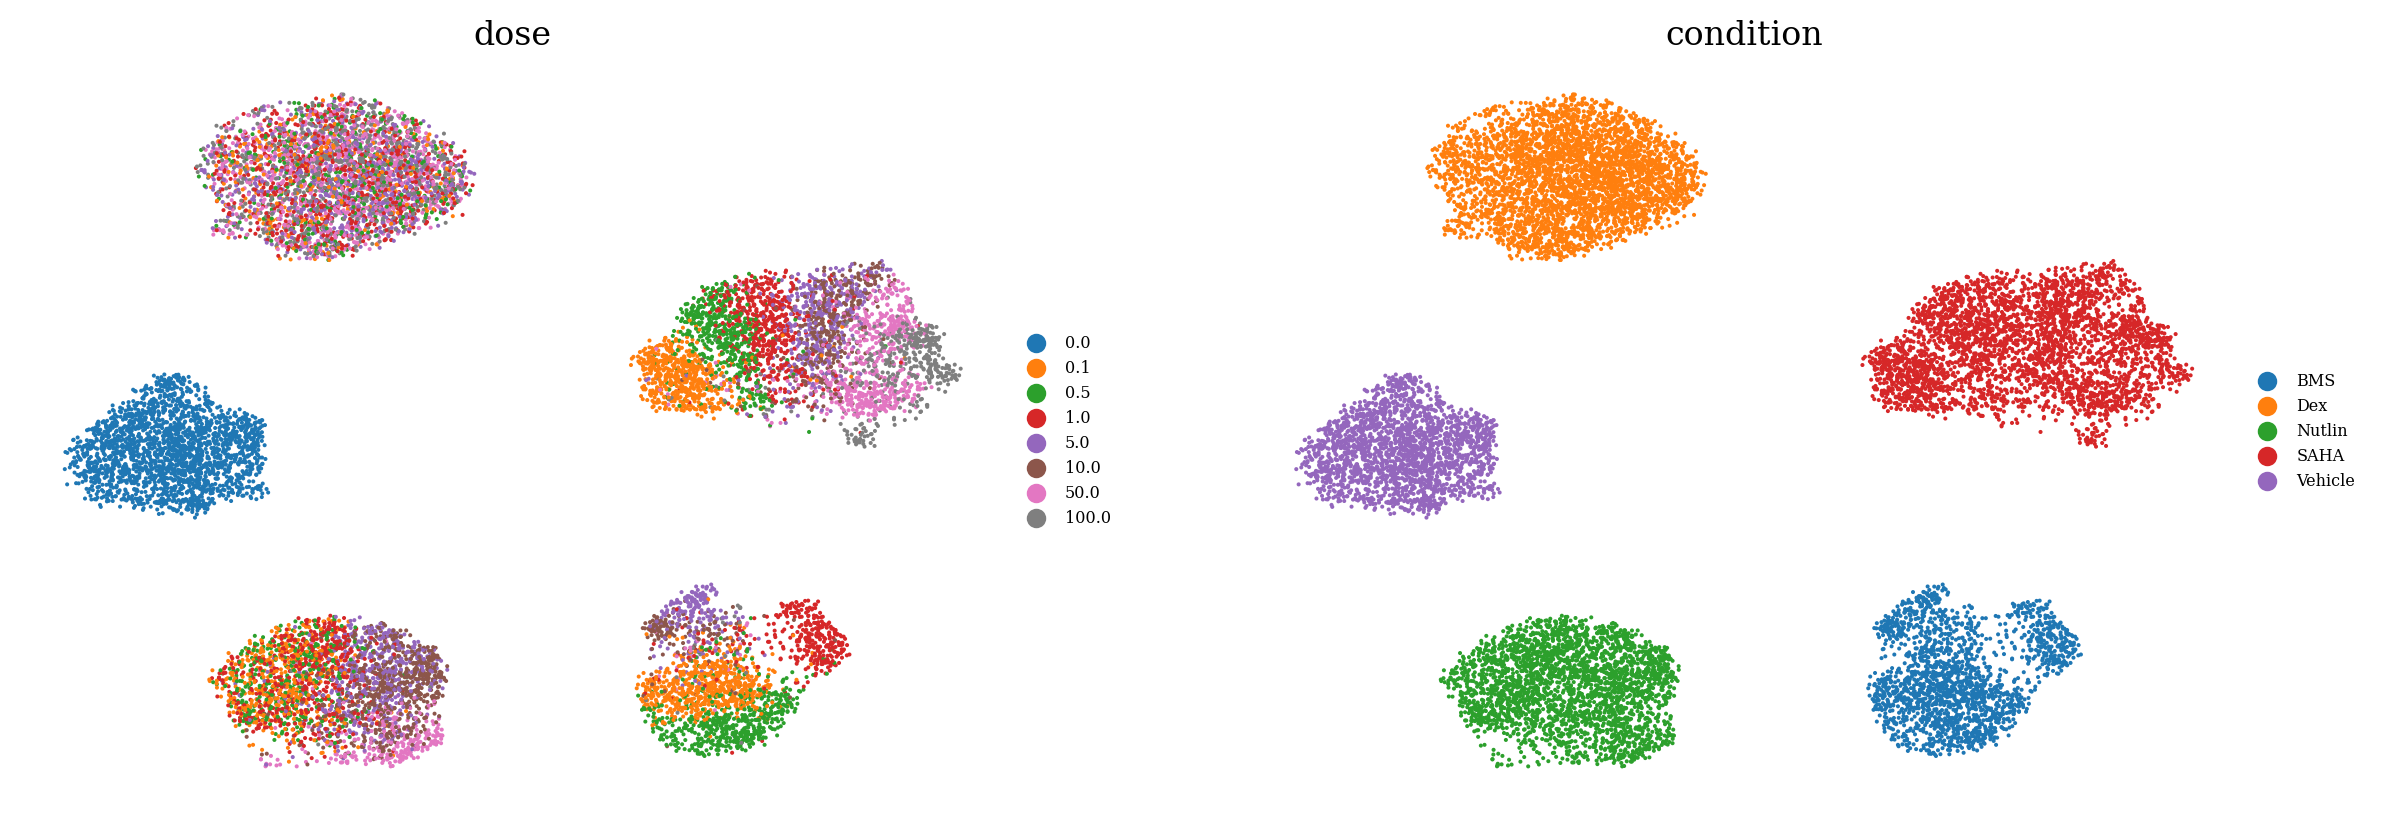

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [24]:
from tardis._disentanglementmanager import DisentanglementManager as DM

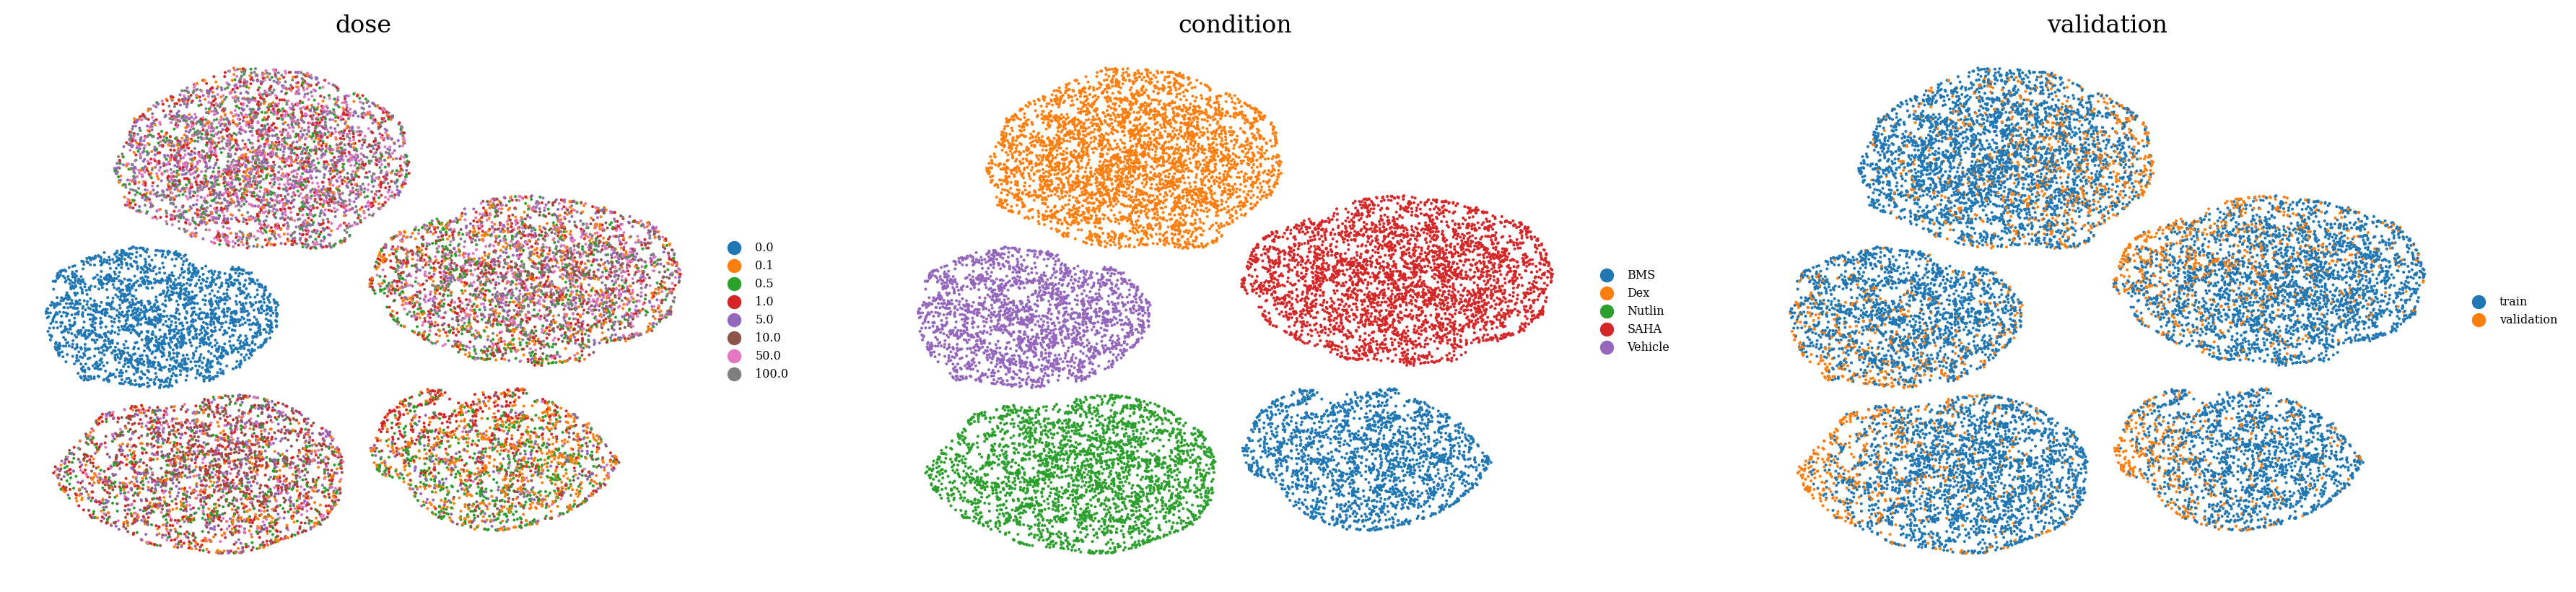

In [25]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key(obs_key).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )